### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">0.0 IMPORTAR BIBILOTECAS</p></div>

In [1]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import sweetviz as sv
import scikitplot as skplt
import pickle
import json
import random

from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings( 'ignore' )

In [2]:
# Ajustar gráficos
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 10

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">0.1 Funções</p></div>

In [3]:
def renomear_colunas( df1 ):
    cols_old = df1.columns
    snakecase = lambda x: inflection.underscore( x )
    cols_new = list( map( snakecase, cols_old ) )
    df1.columns = cols_new

    return df1

def feature_engineering( df2 ):
    # vehicle_age
    df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                               else 'between_1_2_year' if x == '1-2 Year' 
                                               else 'below_1_year' ) 
    # vehicle_damage 
    df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

    return df2

def standardization_data( df5 ):
    #annual_premium
    ss = pp.StandardScaler()
    df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
    pickle.dump(ss, open('../features/annual_premium_scaler.pkl', 'wb'))

    return df5

def rescaling_data( df5 ):
    # age (por causa do gráfico)
    mms_age = pp.MinMaxScaler()
    df5['age'] = mms_age.fit_transform(df5[['age']].values)
    pickle.dump(mms_age, open('../features/age_scaler.pkl', 'wb'))

    # vintage (por causa do gráfico)
    mms_vintage = pp.MinMaxScaler()
    df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
    pickle.dump(mms_vintage, open('../features/vintage_scaler.pkl', 'wb'))

    return df5

def encoding_data( df5 ):
    # gender - Target Encoding / One Hot Encoding 
    target_encode_gender = df5.groupby('gender')['response'].mean()
    df5.loc[:,'gender'] = df5['gender'].map(target_encode_gender)
    pickle.dump(target_encode_gender, open('../features/target_encode_gender_scaler.pkl', 'wb'))

    # region_code (eu achava que era rescaling) -  Target Encoding / Frequency Encoding
    target_encode_region_code = df5.groupby('region_code')['response'].mean()
    df5.loc[:,'region_code'] = df5['region_code'].map(target_encode_region_code)
    pickle.dump(target_encode_region_code, open('../features/target_encode_region_code_scaler.pkl', 'wb'))

    # vehicle_age (variavel categórica)  One Hot Encoding / Order Encoding / Frequency Encoding
    df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

    # policy_sales_channel (eu achava que era rescaling) - Frequency Encoding / Target Encoding
    freq_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
    df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(freq_policy_sales_channel)
    pickle.dump(freq_policy_sales_channel, open('../features/freq_policy_sales_channel_scaler.pkl', 'wb'))
    
    return df5

def precisao_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precisao_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precisao_k']

def recall_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_k']

def modelo_metricas(nome_modelo, y_val, yhat, x_val):

    df8 = x_val.copy()
    df8['response'] = y_val.copy()
    # Pontuação
    df8['score'] = yhat[:,1].tolist()
    # Classificar clientes
    df8 = df8.sort_values( 'score', ascending=False )

    # Calcular Precisão
    precisao = precisao_k ( df8, k=4000 )
    # Calcular Recall
    recall =  recall_k ( df8, k=4000 )

    return pd.DataFrame({'Model Name': nome_modelo,
                         'Precisão at K': precisao,
                         'Recall at K': recall}, index=[0])


### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">0.2 Carregar base de dados</p></div>

In [4]:
df_raw= pd.read_csv( '../datasets/train.csv', low_memory=False )

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.0 DESCRIÇÃO DOS DADOS</p></div>

In [5]:
df1 = df_raw.copy()

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.1 Renomear Colunas</p></div>

In [6]:
# Renomear as colunas para mdoelo snakecase
df1 = renomear_colunas(df1)

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.2 Tamanho dos dados (shape)</p></div>

In [7]:
df1.shape

(381109, 12)

In [8]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.3. Tipo dos Dados (Dtypes)</p></div>

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.4. Checagem de N/As</p></div>

In [10]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.5 Preencher os N/As</p></div>

Como não temos nenhum registro em NA, esta ação não será necessária.

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.6 Tipos de Mudança</p></div>

Não será aplicado nenhuma mudança de tipos de variáveis neste dataframe.

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">1.7 Descrição Estatística dos dados</p></div>

Métricas de tendência central : 

- media 
- mediana

Métricas de dispersão : 

- desvio padrão
- valor minimo
- valor máximo
- faixa(range) 
- skew(inclinação)
- curtose 

In [11]:
numericos = df1.select_dtypes(include=['int64','float64' ])
categoricos = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])

### <div style="color:red;border-radius:25px;background-color:#87CEEB;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:black;overflow:hidden;text-align: center;margin:0;font-size:100%">1.7.1 Atributos Numéricos</p></div>

In [12]:
# Métricas de tendência central 
media = pd.DataFrame ( numericos.apply(np.mean)).T
mediana = pd.DataFrame ( numericos.apply(np.median)).T

In [13]:
# Métricas de dispersão
desvio_padrao = pd.DataFrame ( numericos.apply(np.std)).round(2).T
minimo = pd.DataFrame ( numericos.apply(min)).round(2).T
maximo = pd.DataFrame ( numericos.apply(max)).round(2).T
faixa = pd.DataFrame ( numericos.apply(lambda x: x.max() - x.min())).round(2).T
inclinação = pd.DataFrame ( numericos.apply(lambda x: x.skew() )).round(2).T
curtose = pd.DataFrame ( numericos.apply(lambda x: x.kurtosis())).round(2).T

In [14]:
#Concatenar
metricas = pd.concat([minimo, maximo, faixa, media, mediana, desvio_padrao, inclinação, curtose ]).T.reset_index()
metricas.columns = ['attributes','min','max','range','mean', 'median', 'std', 'skew','kurtosis' ]
metricas

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.69,0.00,-1.20
1,age,20.0,85.0,65.0,38.822584,36.0,15.51,0.67,-0.57
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.05,-21.60,464.35
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.23,-0.12,-0.87
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.50,0.17,-1.97
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.13,1.77,34.00
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.20,-0.90,-0.97
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.67,0.00,-1.20
8,response,0.0,1.0,1.0,0.122563,0.0,0.33,2.30,3.30


### <div style="color:red;border-radius:25px;background-color:#87CEEB;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:black;overflow:hidden;text-align: center;margin:0;font-size:100%">1.7.2 Atributos Categóricos</p></div>

In [15]:
# Quantos niveis cada variável categorica possui ?
categoricos.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<Axes: xlabel='vehicle_damage', ylabel='response'>

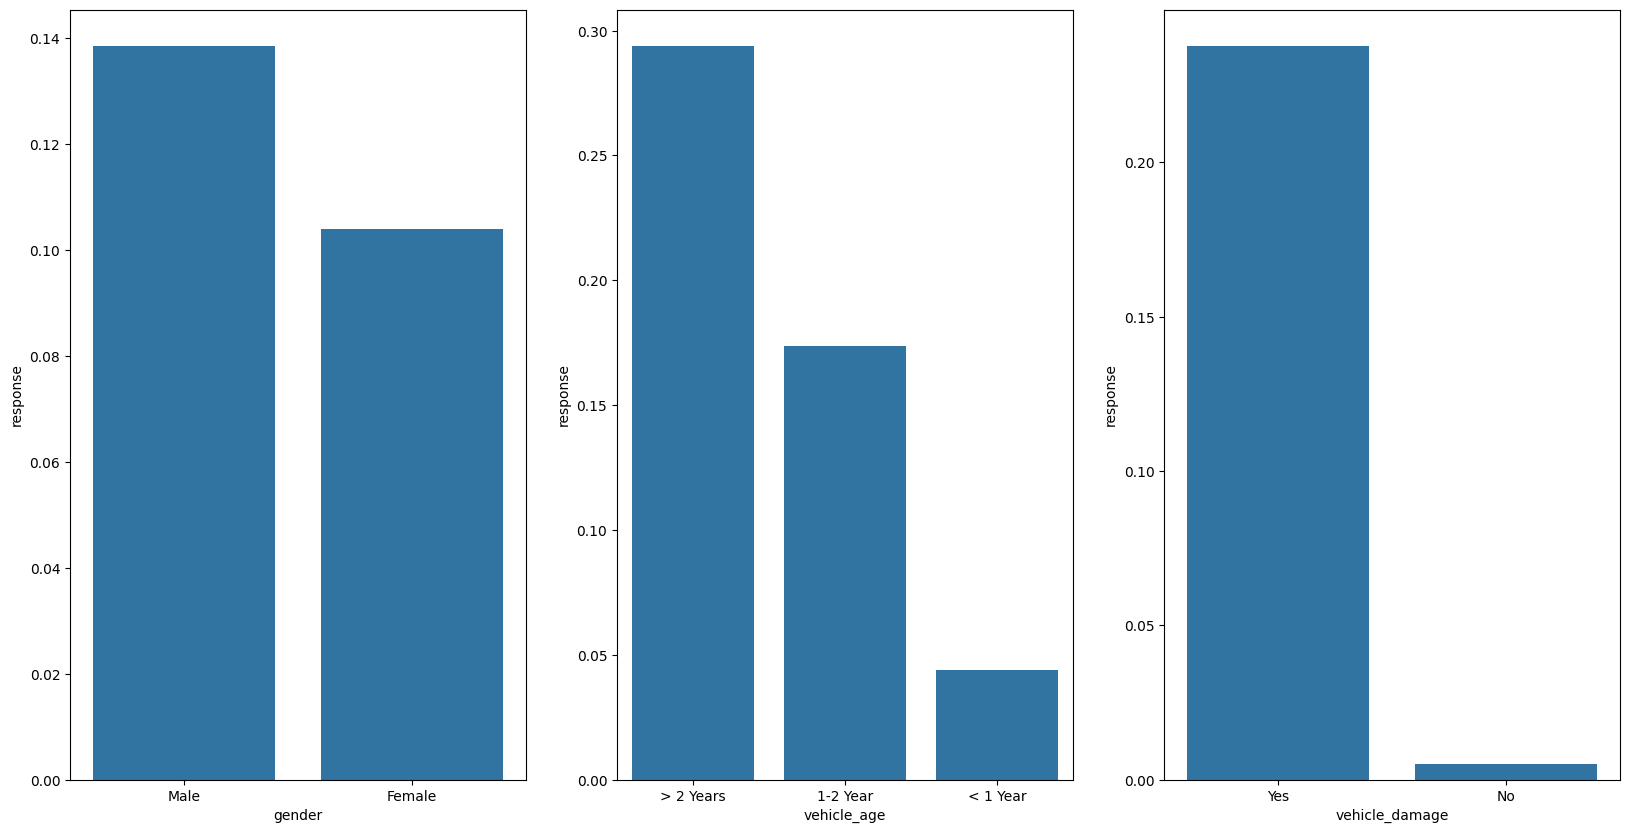

In [16]:
plt.subplot(1,3,1)
sns.barplot(x='gender', y='response', data=df1, errorbar=None)

plt.subplot(1,3,2)
sns.barplot(x='vehicle_age', y='response', data=df1, errorbar=None)

plt.subplot(1,3,3)
sns.barplot(x='vehicle_damage', y='response', data=df1, errorbar=None)

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">2.0 FEATURE ENGINEERING</p></div>

Criação de novas features para facilitar a analise da base de dados

In [17]:
df2 = df1.copy()

In [18]:
df2 = feature_engineering( df2 )

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">3.0 FILTRAGEM DE VARIÁVEIS</p></div>

In [19]:
df3 = df2.copy()

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">4.0 ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)</p></div>

In [20]:
df4 = df3.copy()

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">4.1 Análise Univariada</p></div>

<Axes: xlabel='response', ylabel='age'>

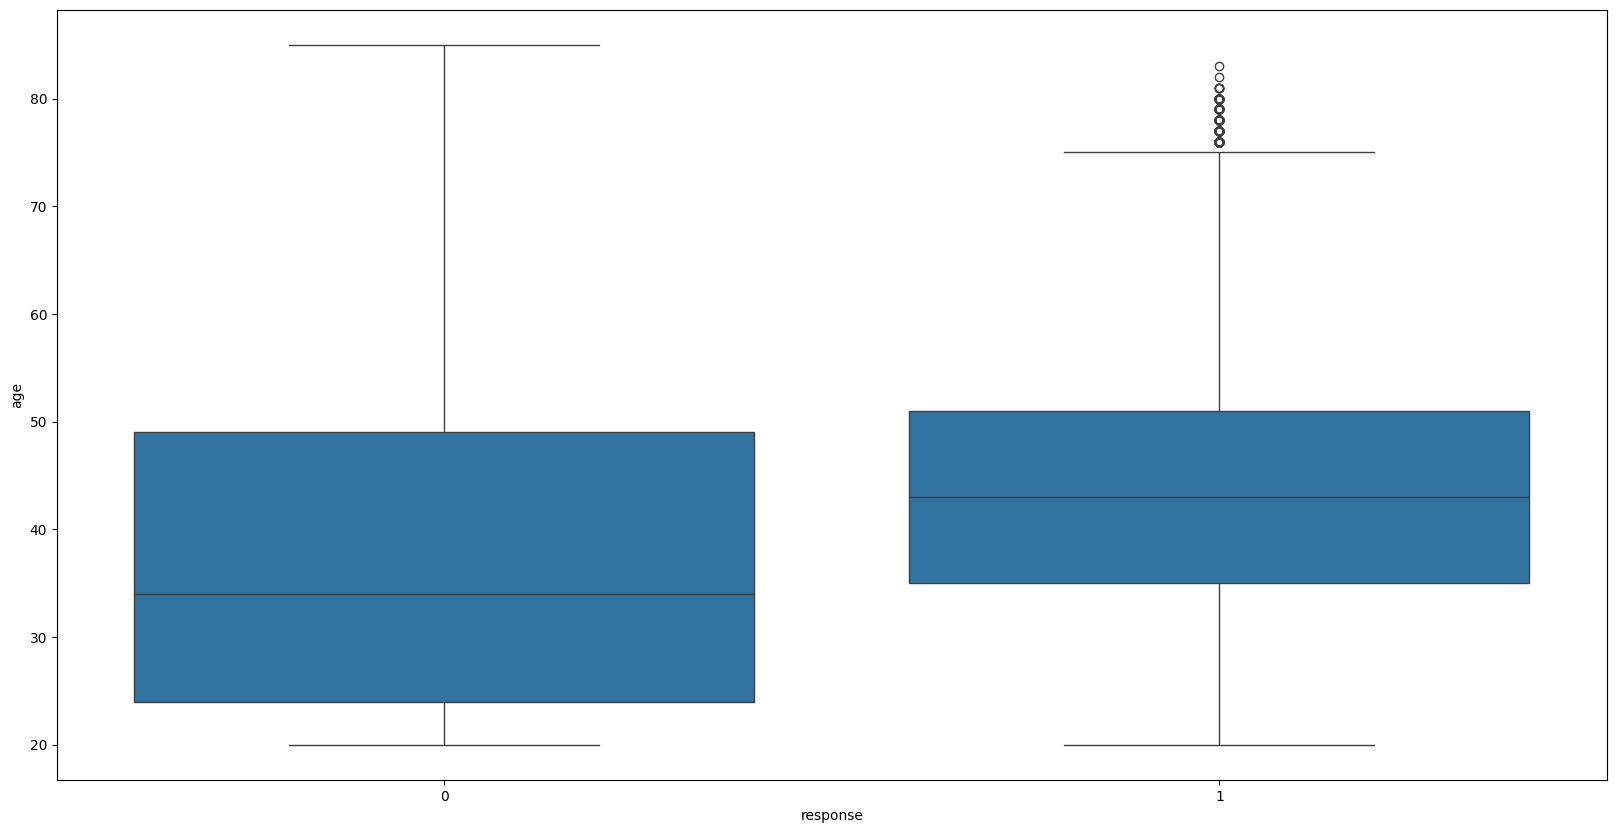

In [21]:
# age
sns.boxplot(x='response', y='age', data=df4)

<Axes: xlabel='age', ylabel='Count'>

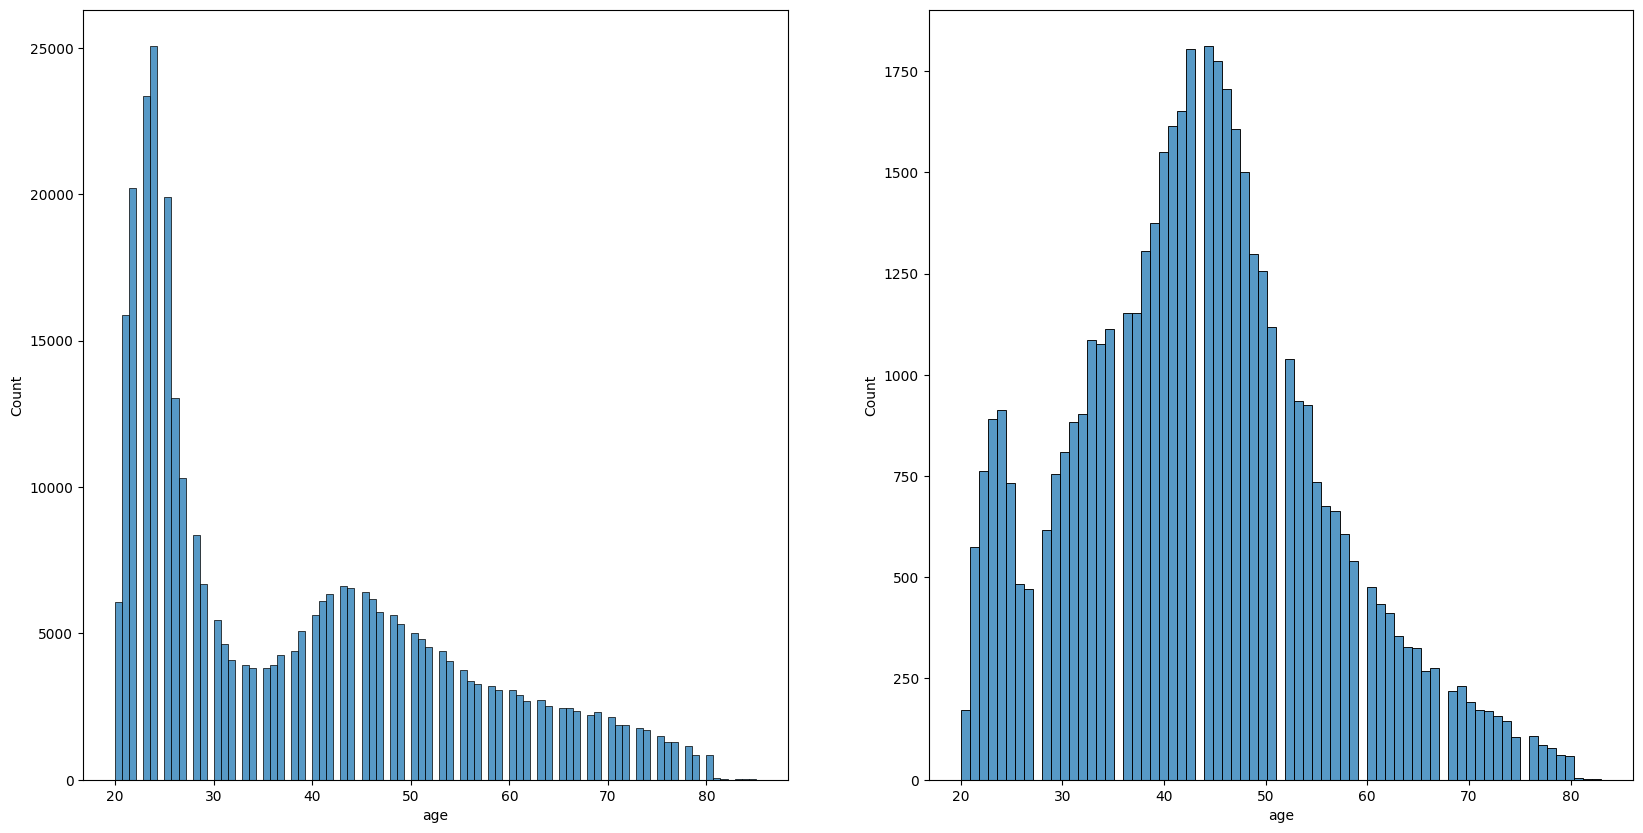

In [22]:
plt.subplot(1, 2, 1)
# Age of response = 0
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
# Age of response = 1
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1)

<Axes: xlabel='response', ylabel='annual_premium'>

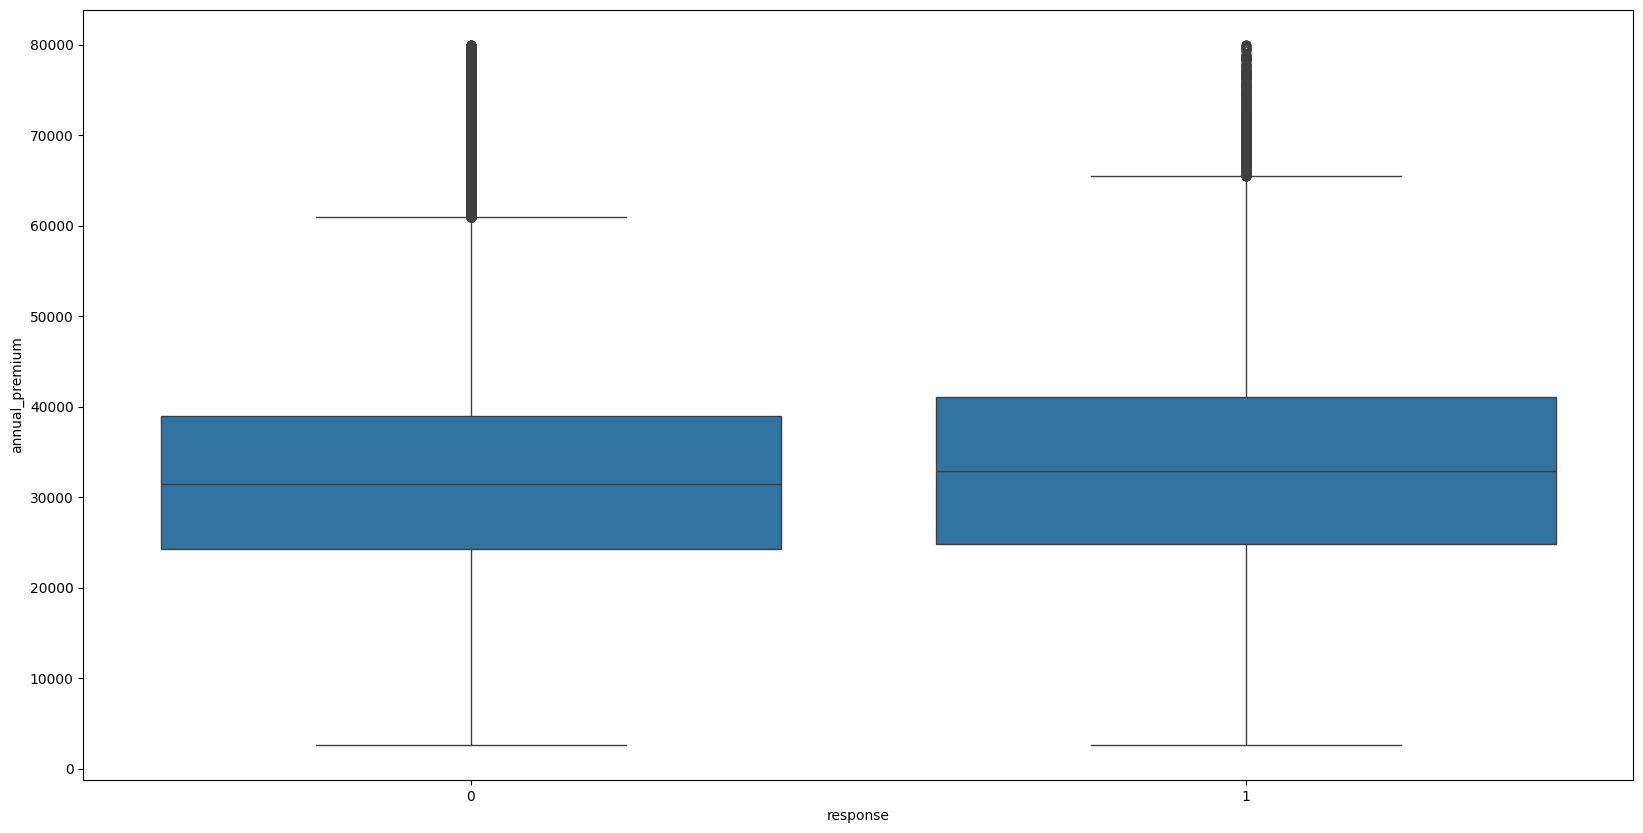

In [23]:
# annual_premium
aux = df4[df4['annual_premium']<80000] # aplicado este filtro porque tinha outliers, não dá pra ver nada
sns.boxplot(x='response', y='annual_premium', data=aux)


<Axes: xlabel='annual_premium', ylabel='Count'>

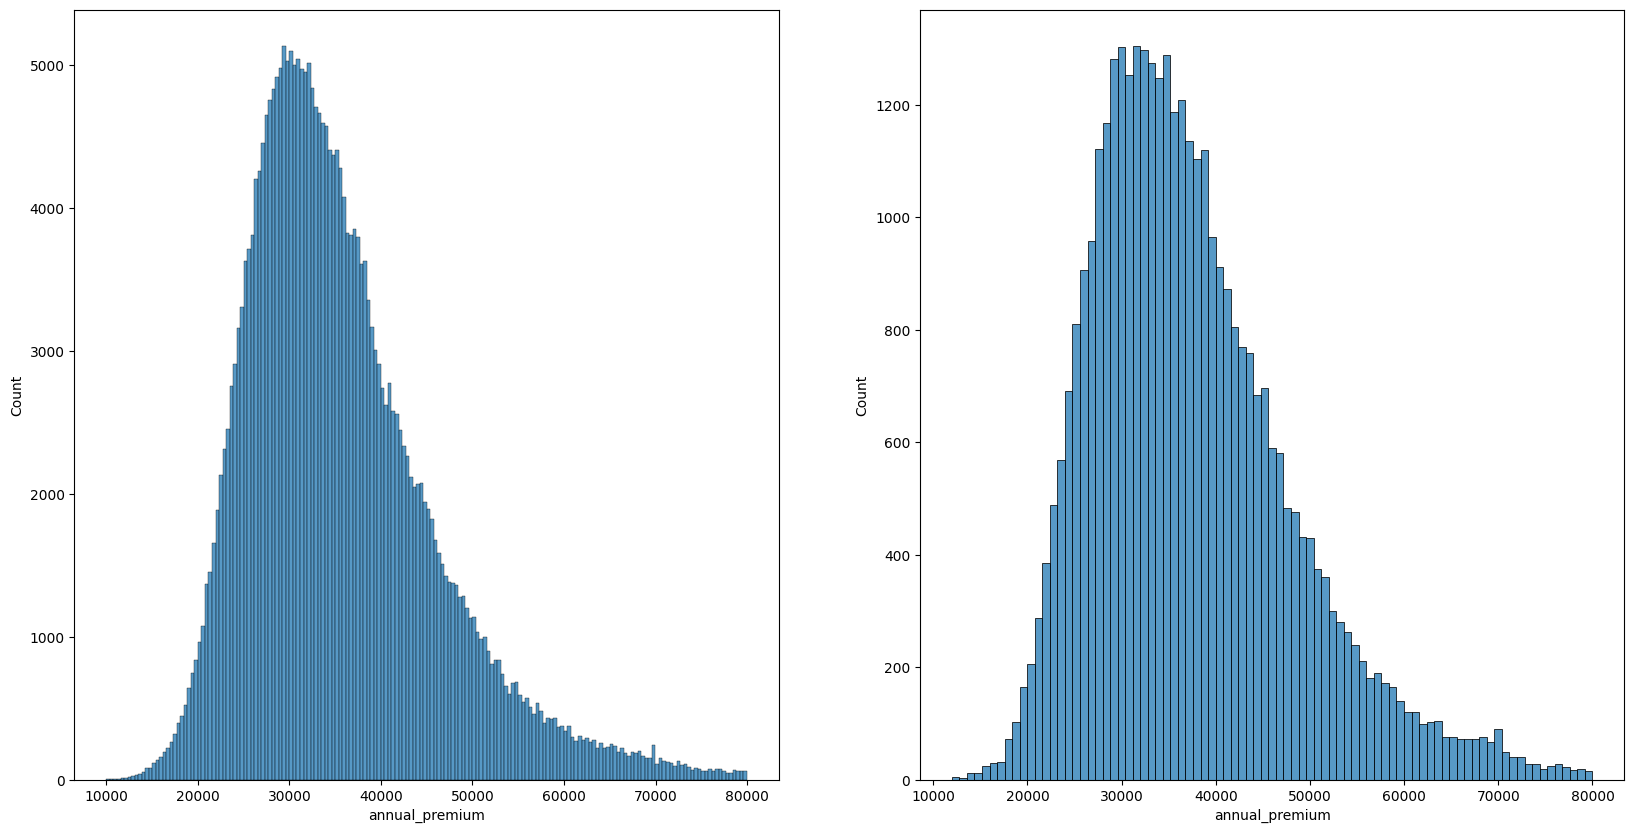

In [24]:
aux = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]

plt.subplot(1, 2, 1)
# annual_premium of response = 0
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
# annual_premium of response = 1
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1)

In [25]:
# driving_licence
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] /  aux['driving_license'].sum()
aux

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='response', ylabel='driving_license'>

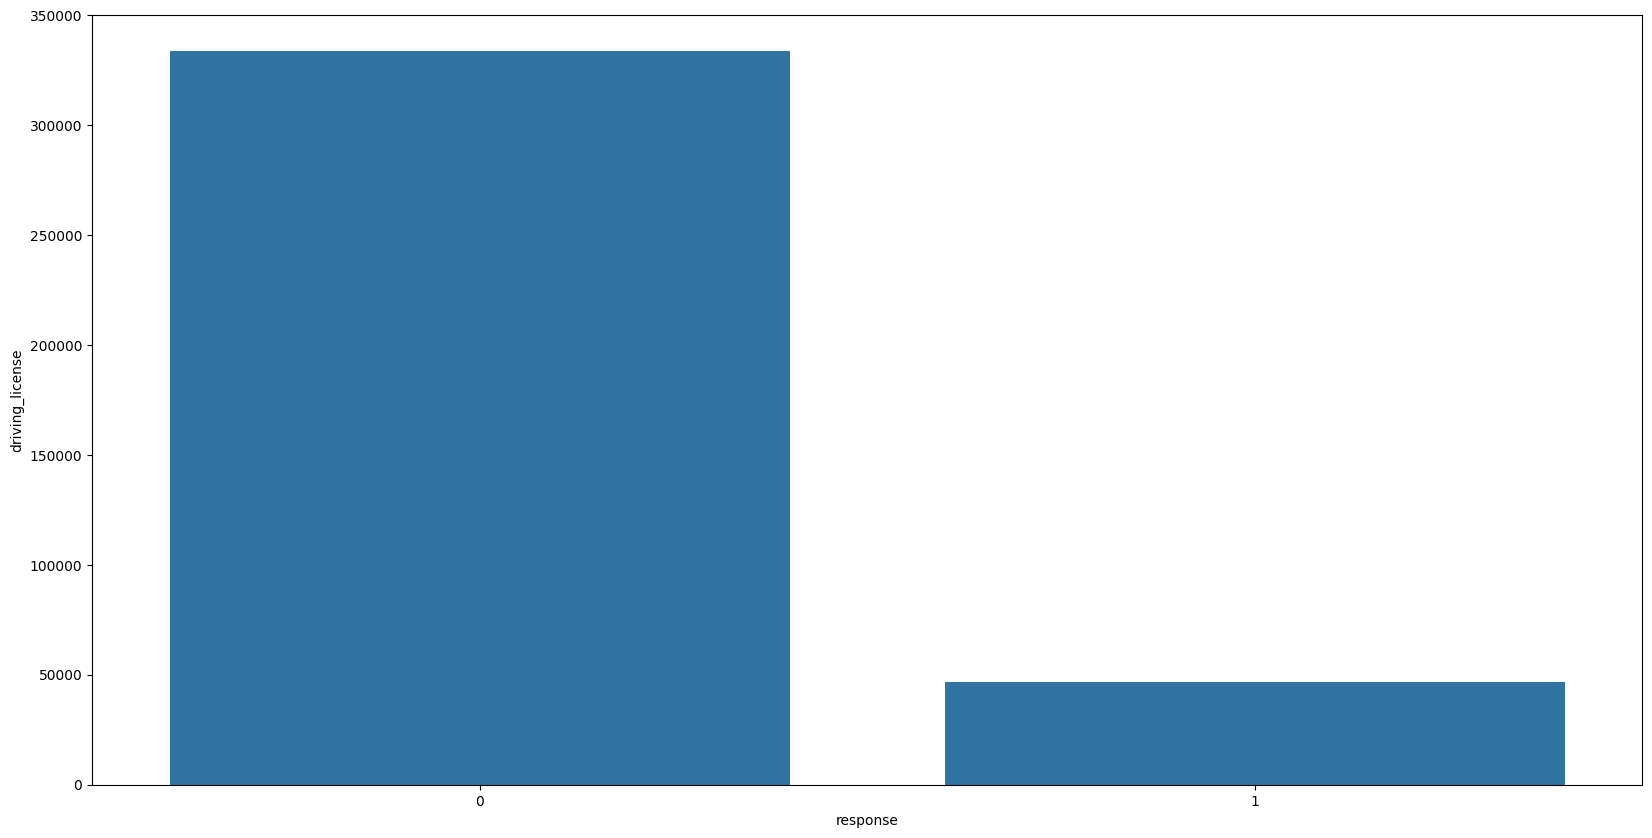

In [26]:
sns.barplot(x='response', y='driving_license', data=aux)
# Mais pessoas que não dirigem e que não querem o seguro de carro (quase 88%)

<Axes: xlabel='region_code', ylabel='id'>

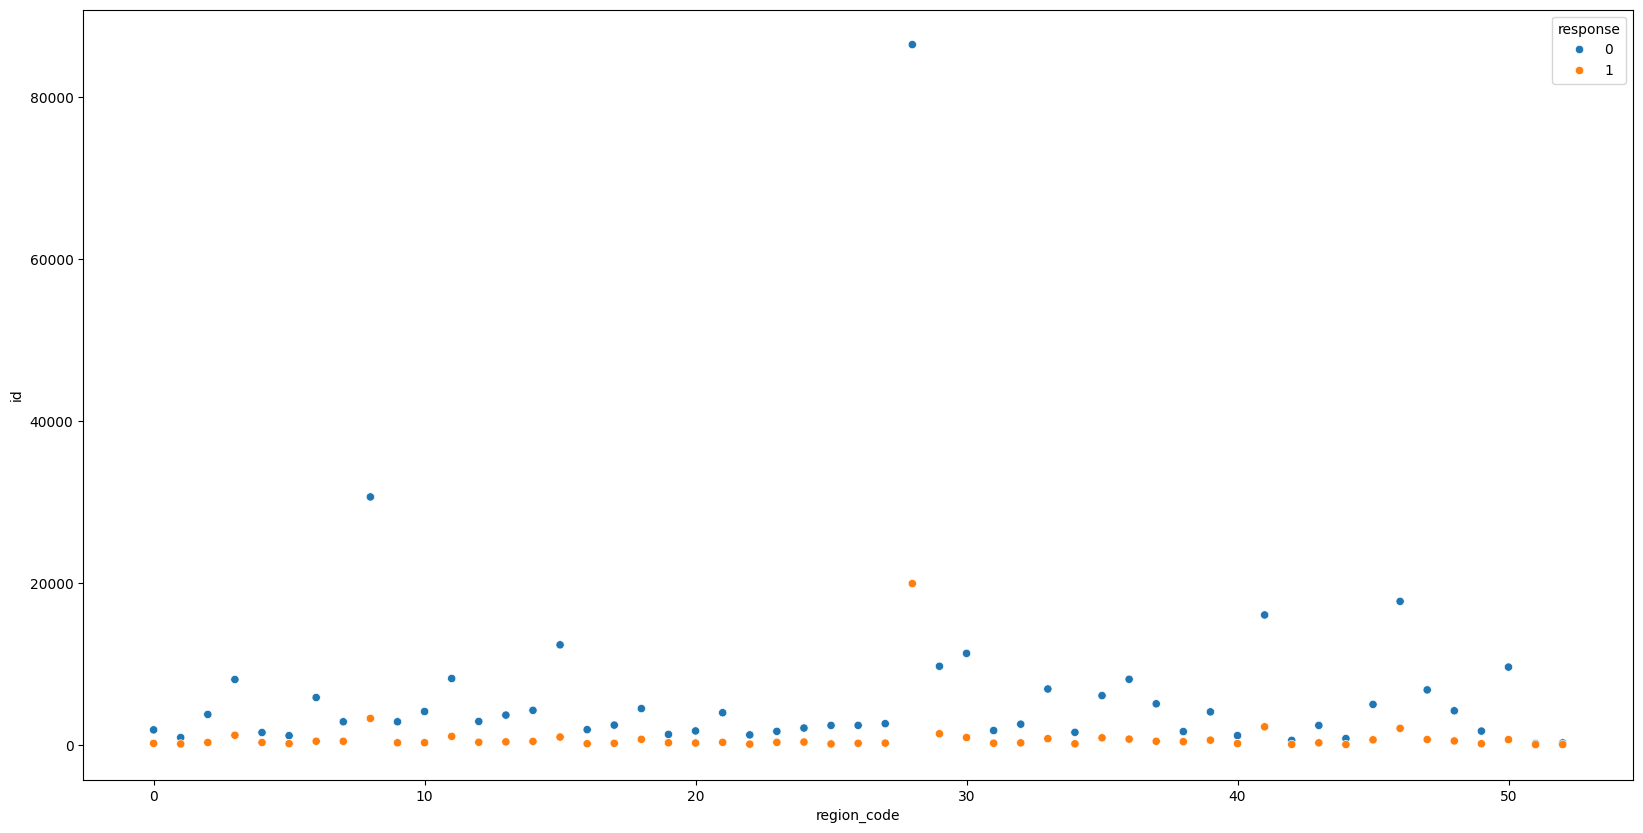

In [27]:
# region_code
aux0 = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux0)

In [28]:
# previously_insured
pd.crosstab(df4['previously_insured'],df4['response'])

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


- 0 0 = Pessoas que NÃO tem seguro de saúde e NÃO querem o seguro de carro
- 0 1 = Pessoas que NÃO tem seguro de saúde e querem o seguro de carro
- 1 0 = Pessoas que tem seguro de saúde e querem NÃO o seguro de carro
- 1 1 = Pessoas que tem seguro de saúde e querem o seguro de carro

In [29]:
pd.crosstab(df4['previously_insured'],df4['response']).apply(lambda x:  x / x.sum(),axis=1)

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


In [30]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts().reset_index()


,vehicle_age,response,count
0,between_1_2_year,0,165510
1,below_1_year,0,157584
2,between_1_2_year,1,34806
3,over_2_years,0,11305
4,below_1_year,1,7202
5,over_2_years,1,4702


In [31]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


<Axes: xlabel='response', ylabel='policy_sales_channel'>

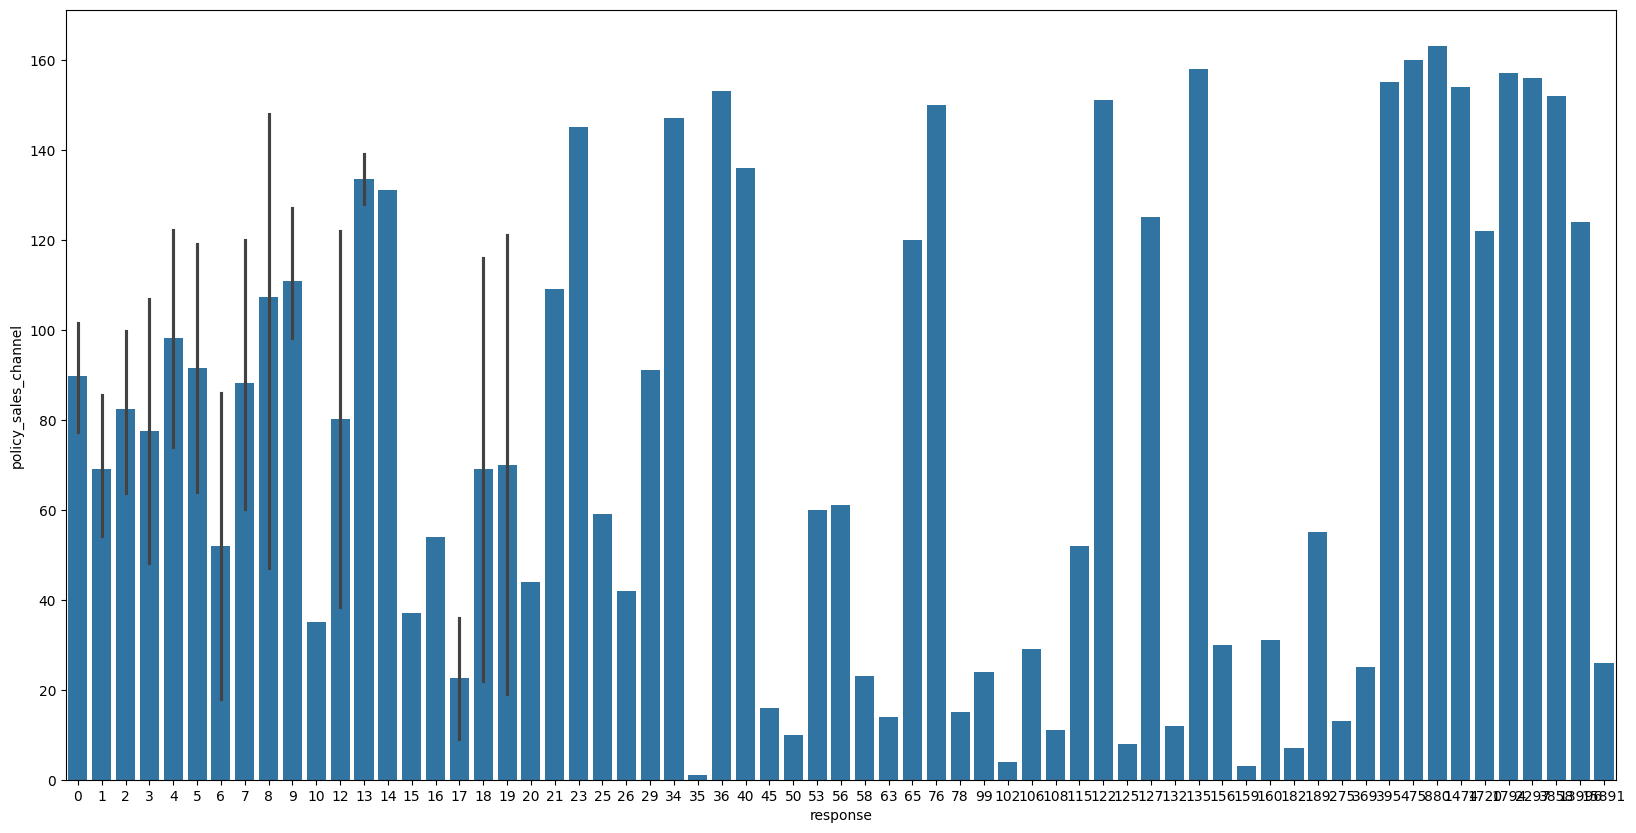

In [32]:
# policy_sales_channel
aux = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot (x='response', y='policy_sales_channel', data=aux)

<Axes: xlabel='response', ylabel='vintage'>

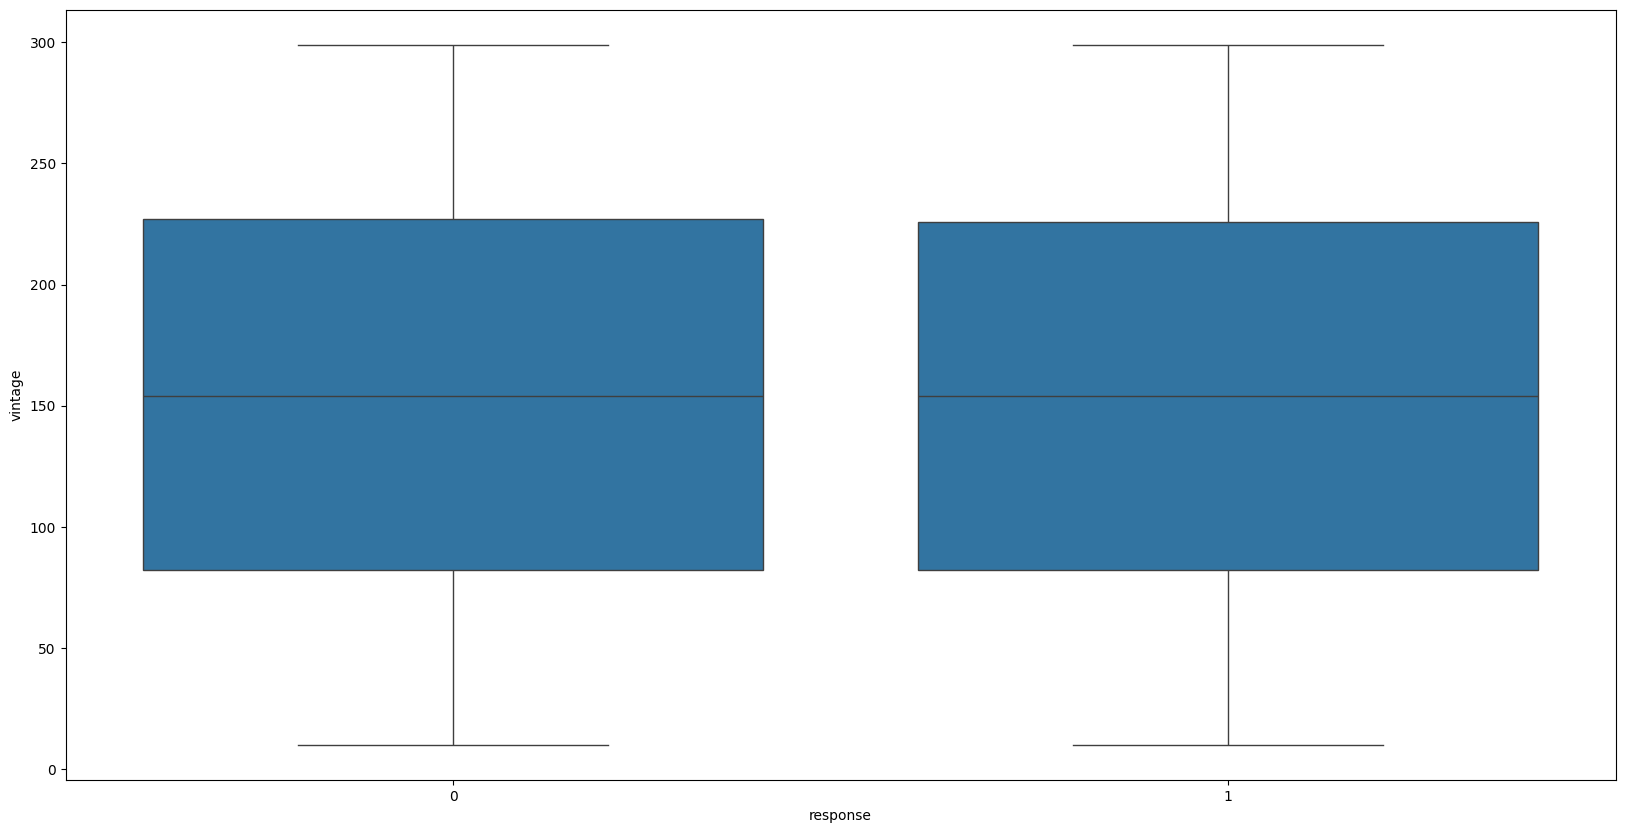

In [33]:
# vintage
sns.boxplot(x='response', y='vintage', data=df4)

<Axes: xlabel='vintage', ylabel='Count'>

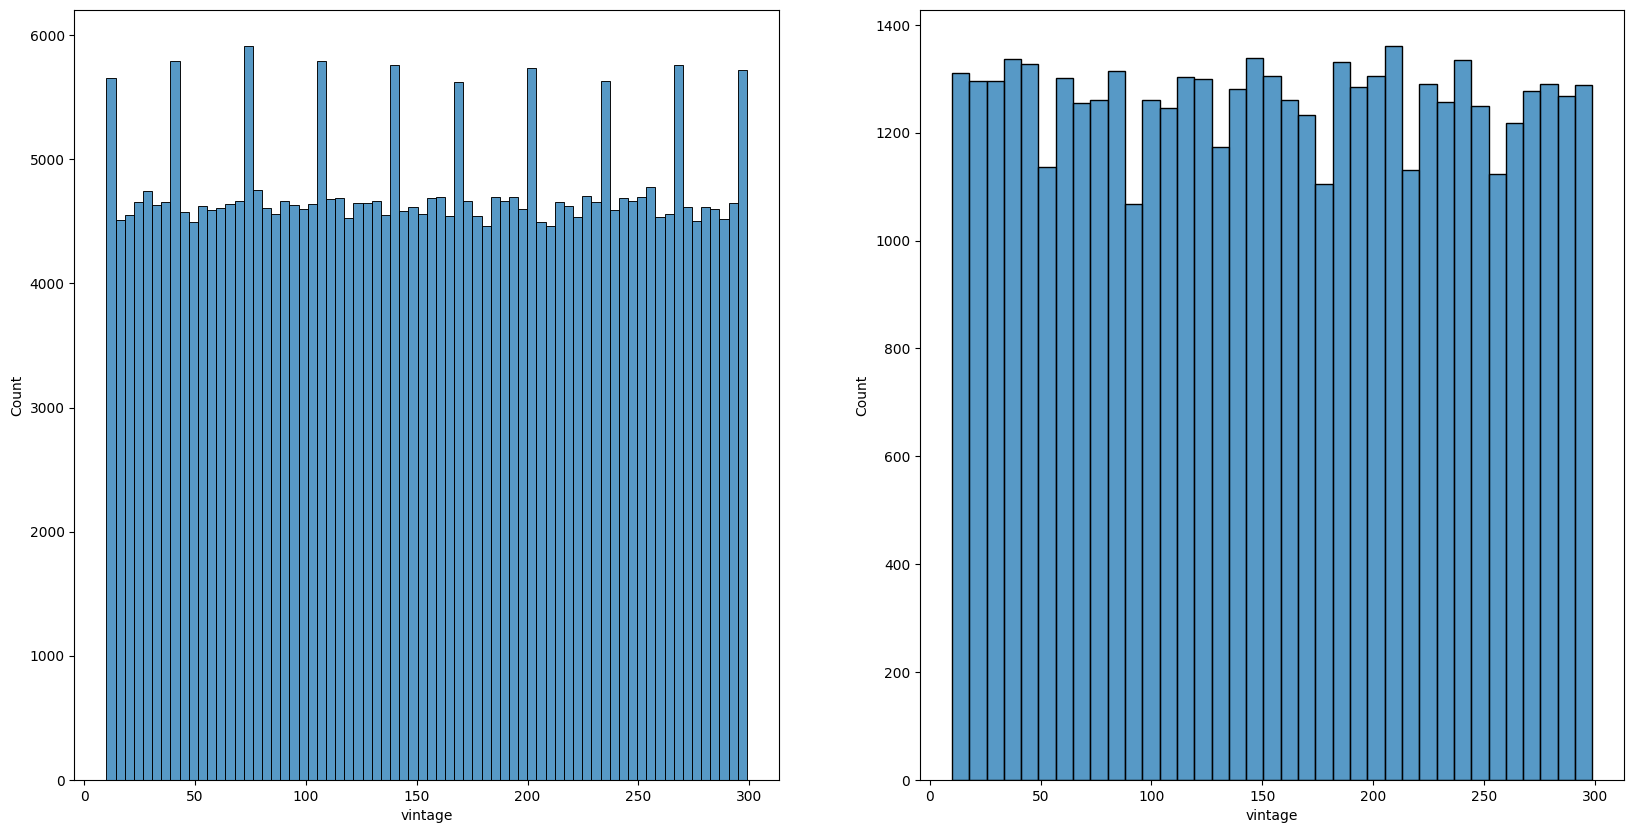

In [34]:
plt.subplot(1, 2, 1)
# Age of response = 0
aux0 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
# Age of response = 1
aux1 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux1)

                                             |          | [  0%]   00:00 -> (? left)


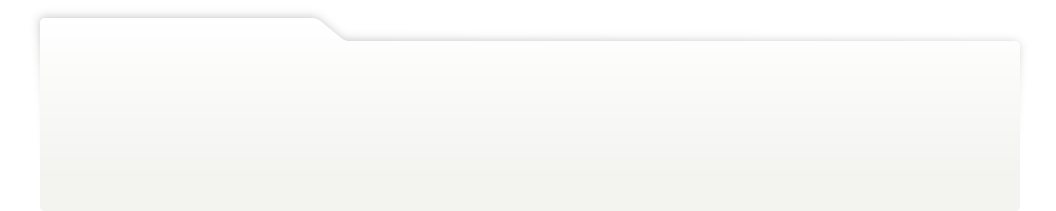
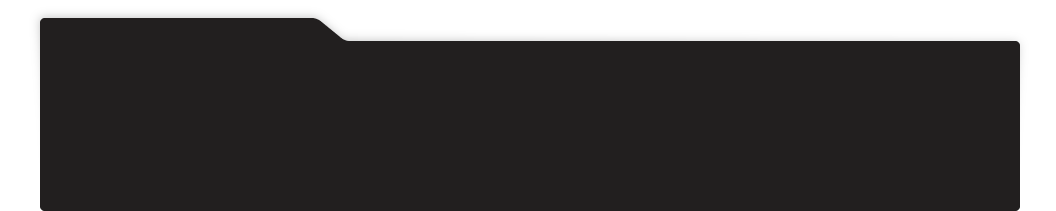
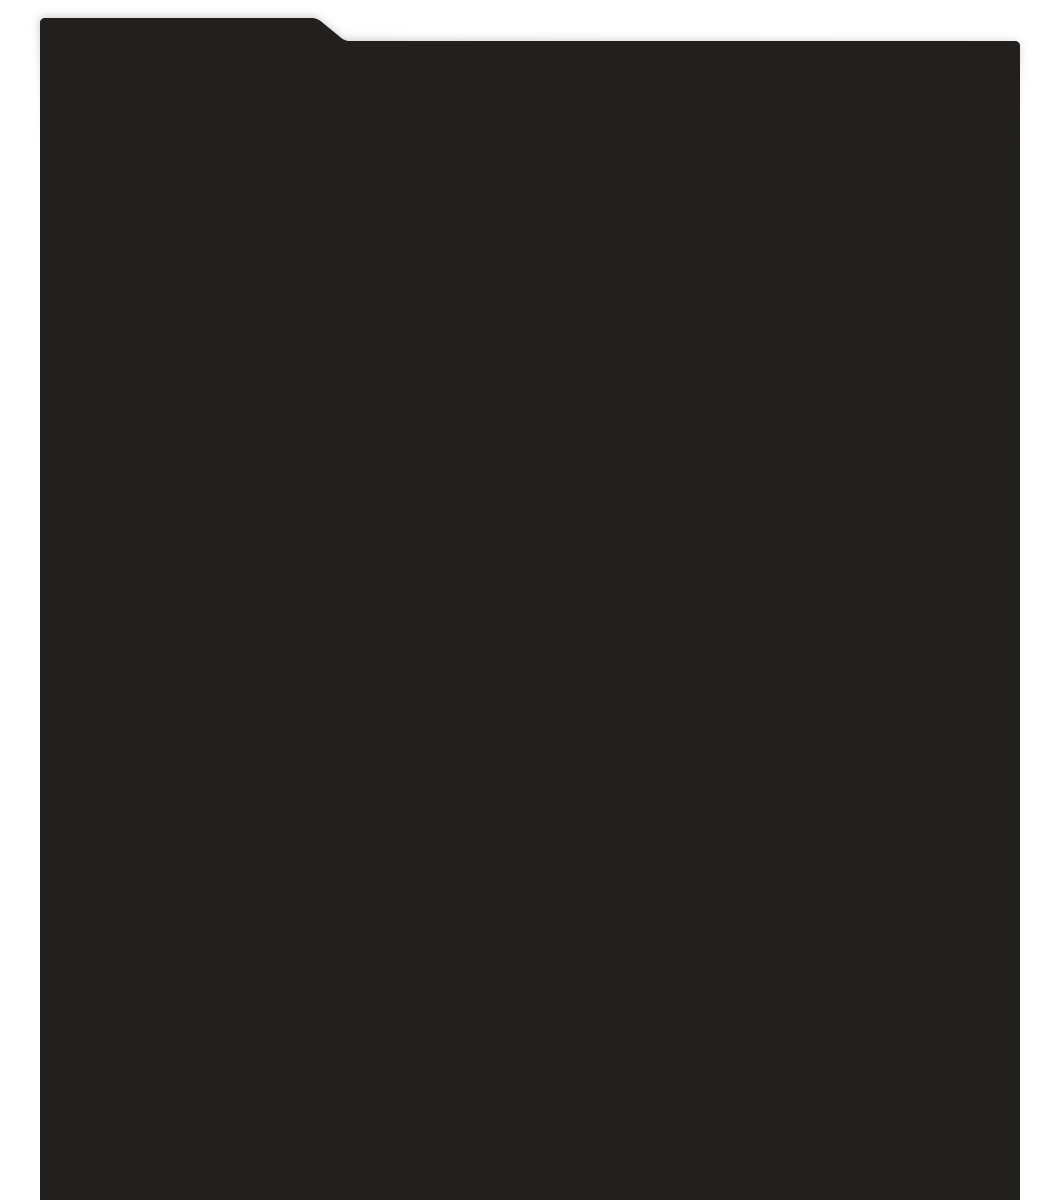
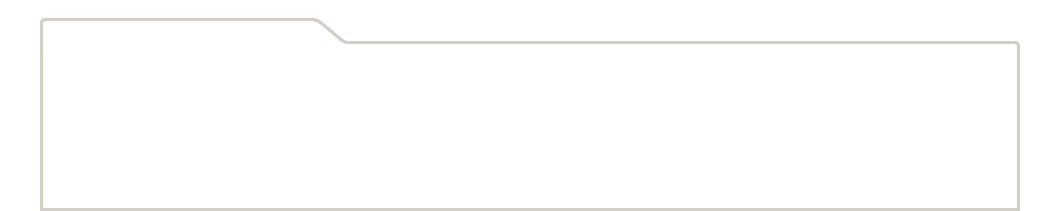
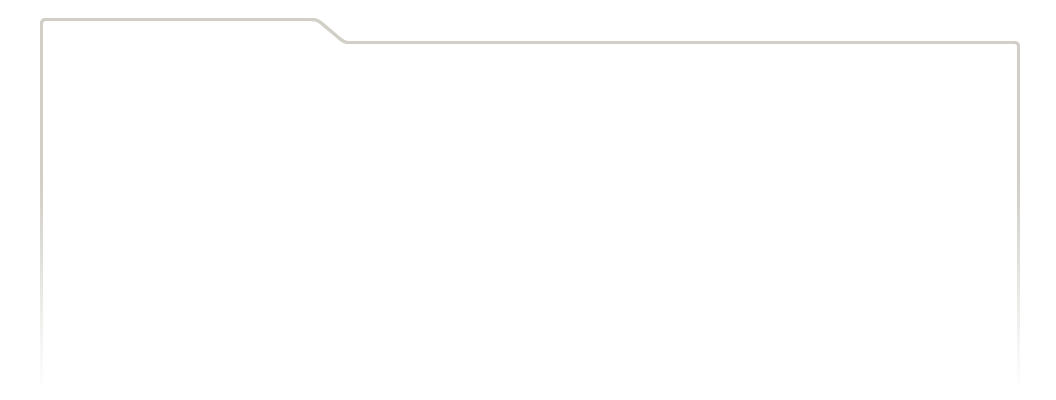
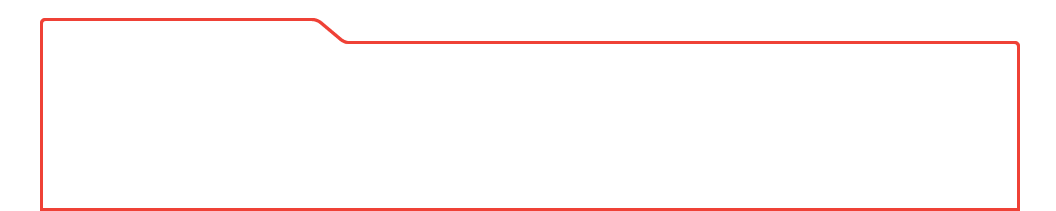
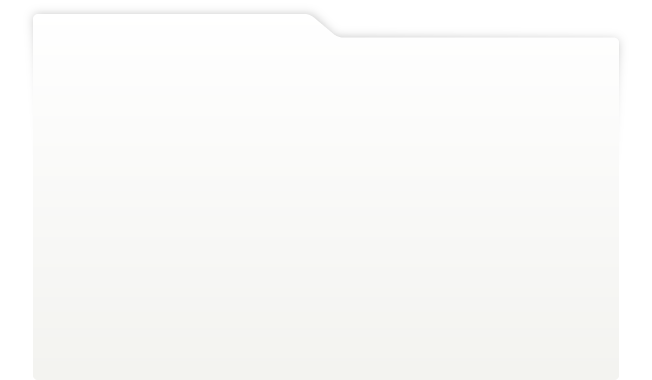
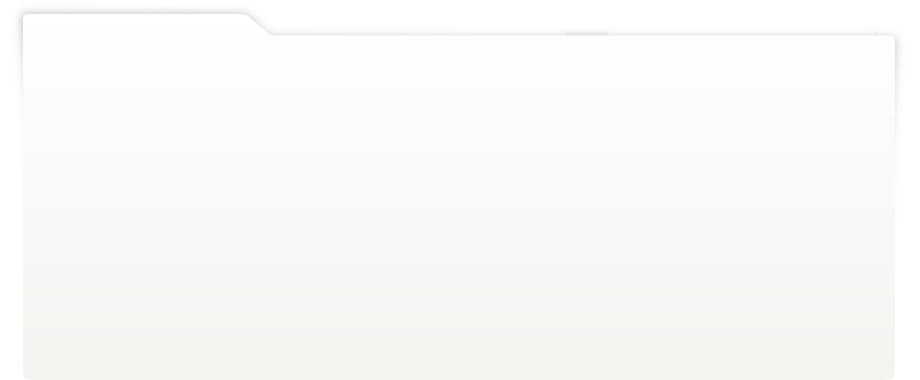
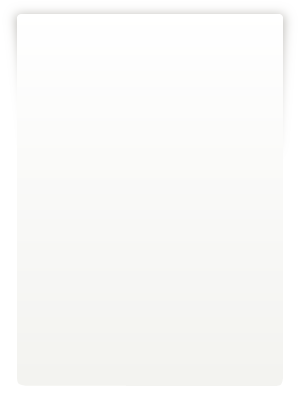
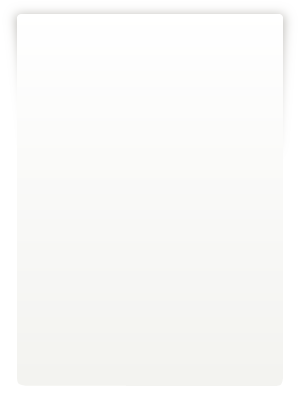
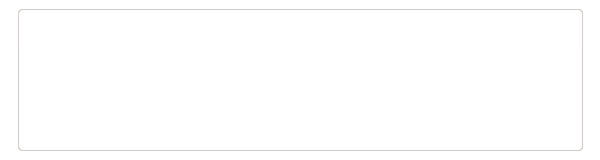
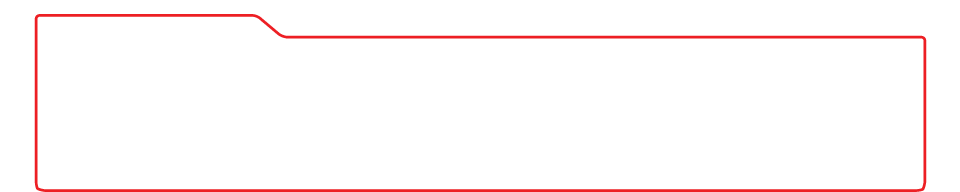
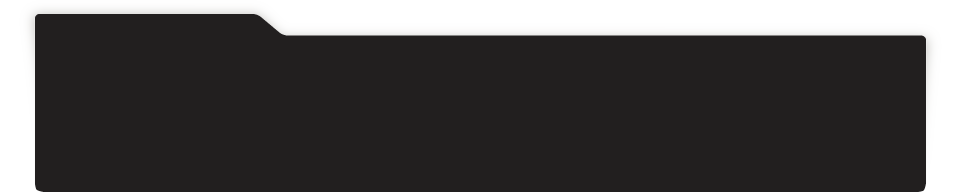
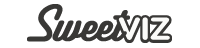
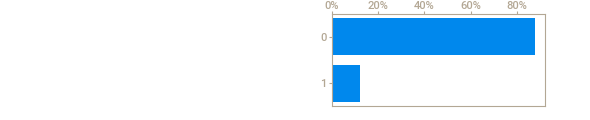
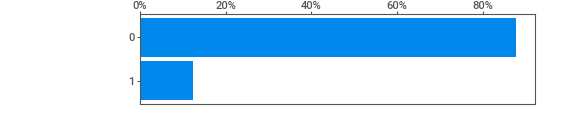
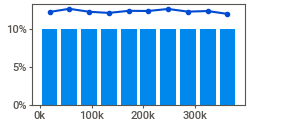
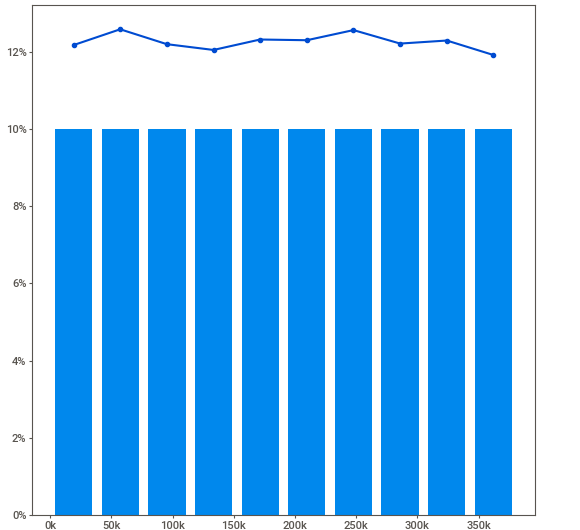
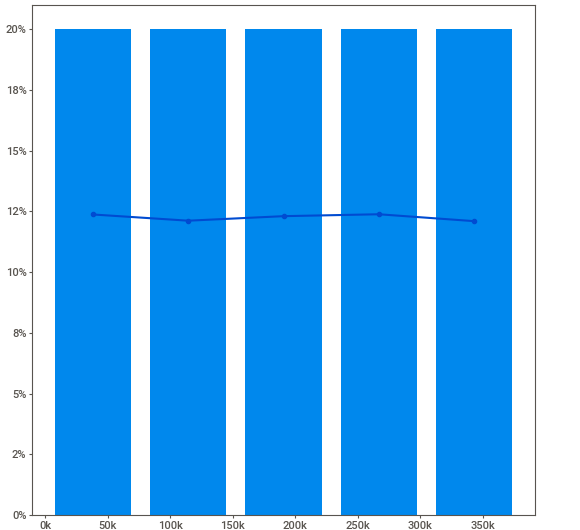
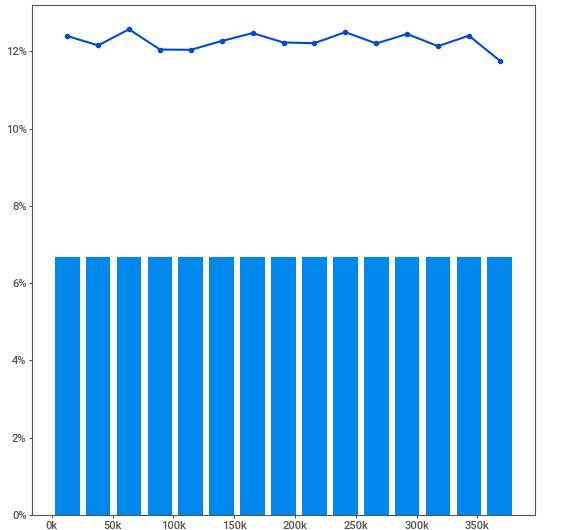
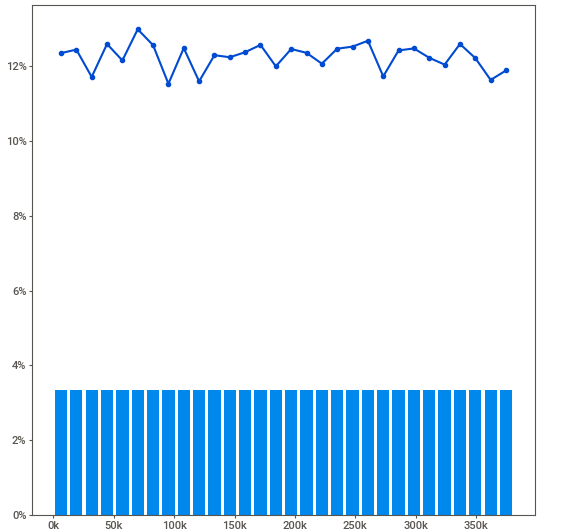
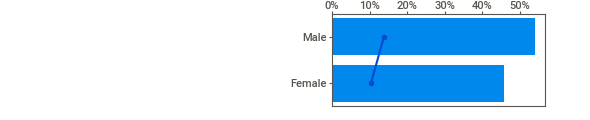
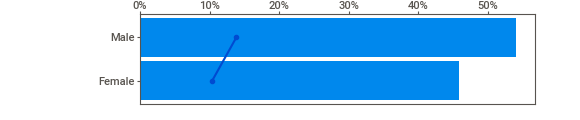
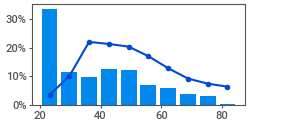
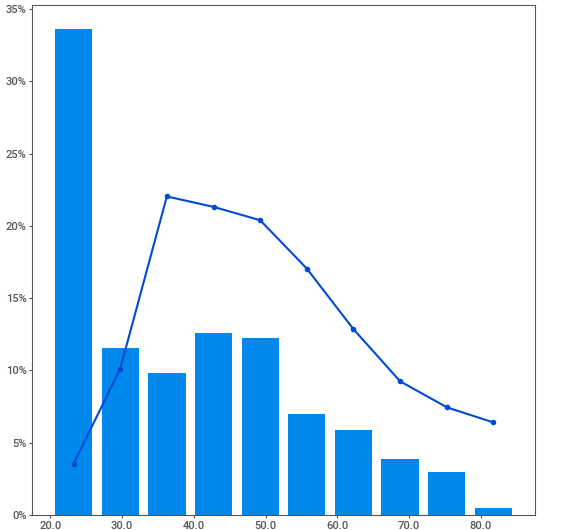
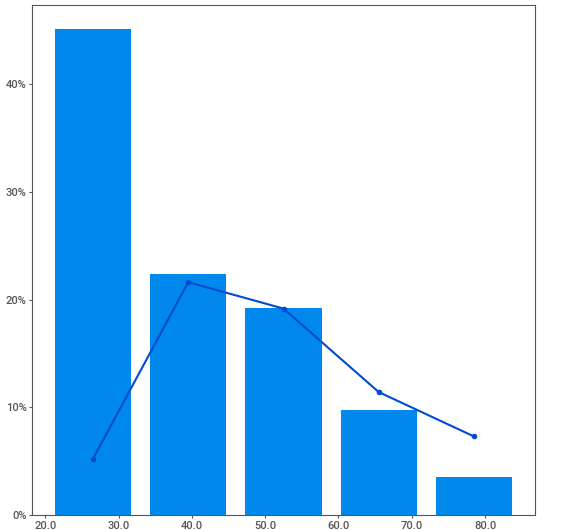
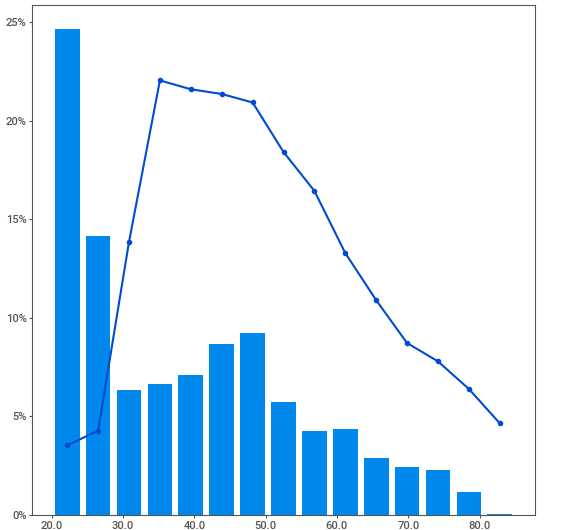
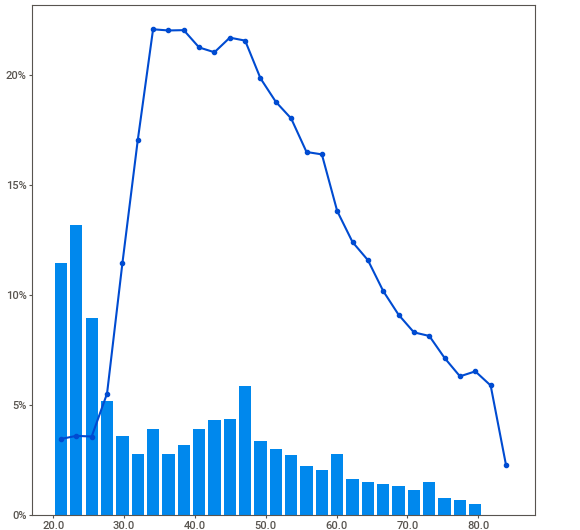
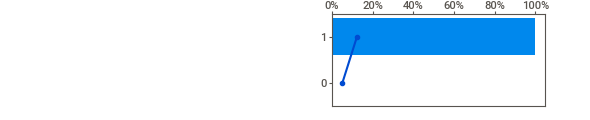
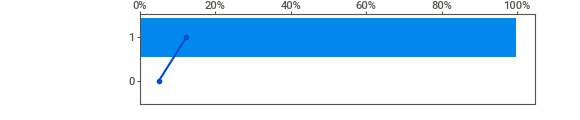
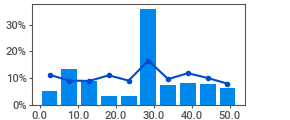
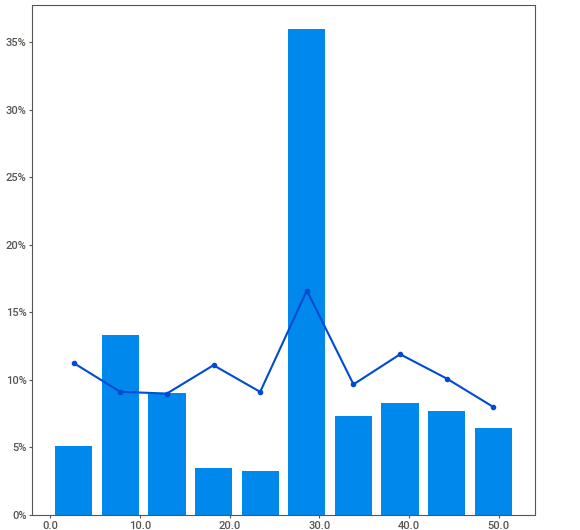
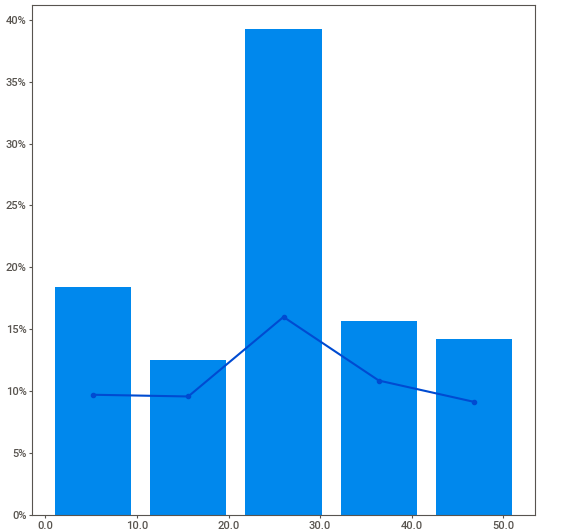
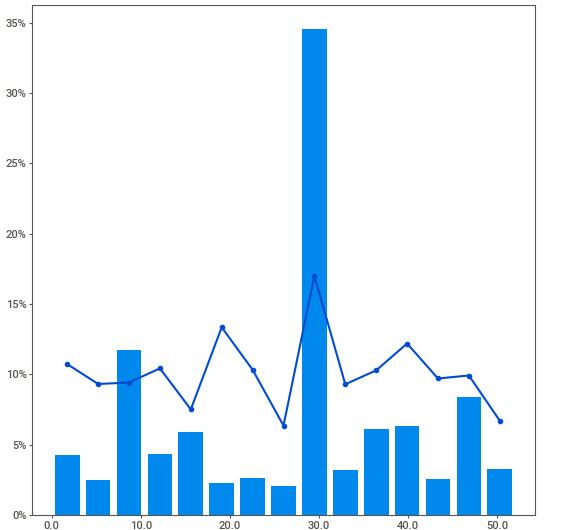
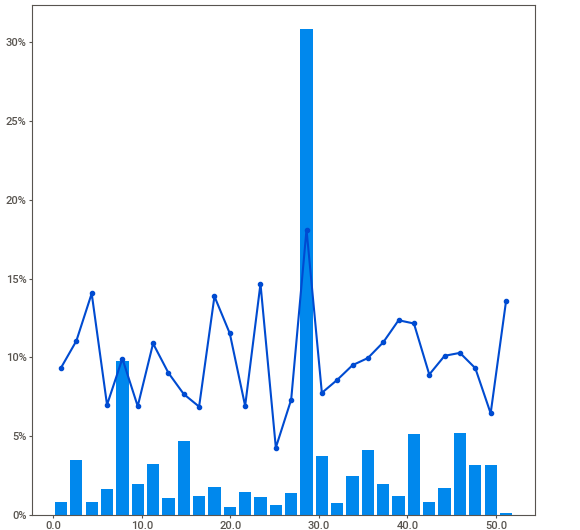
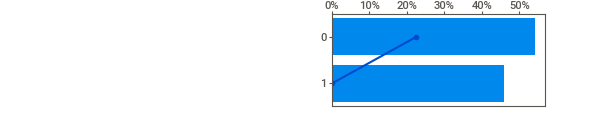
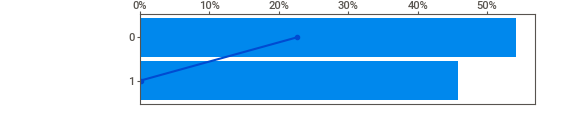
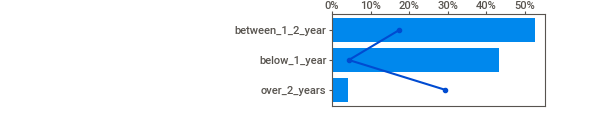
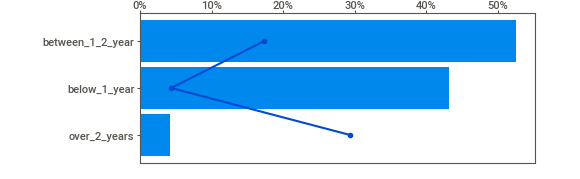
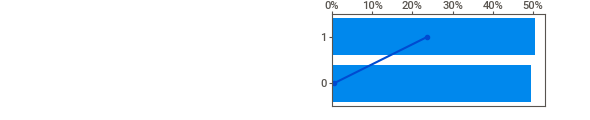
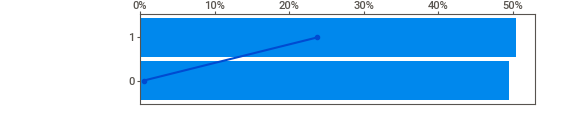
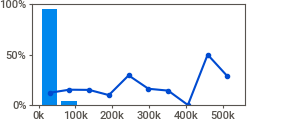
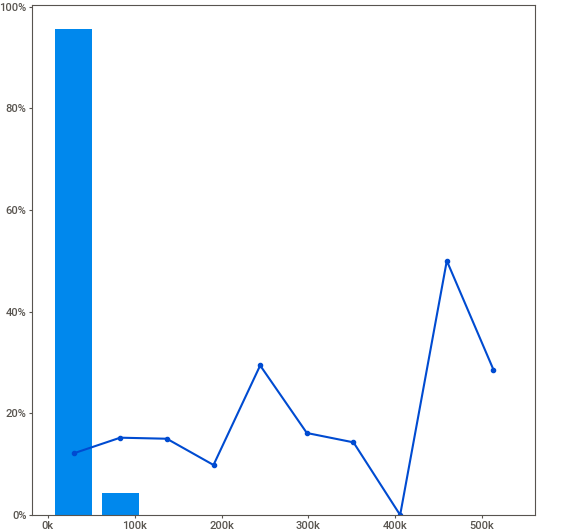
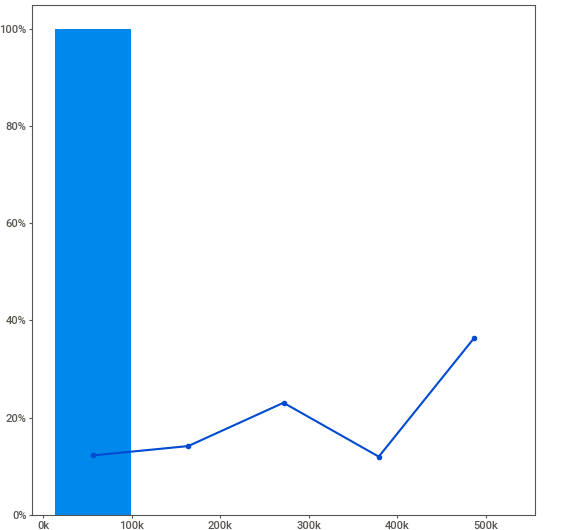
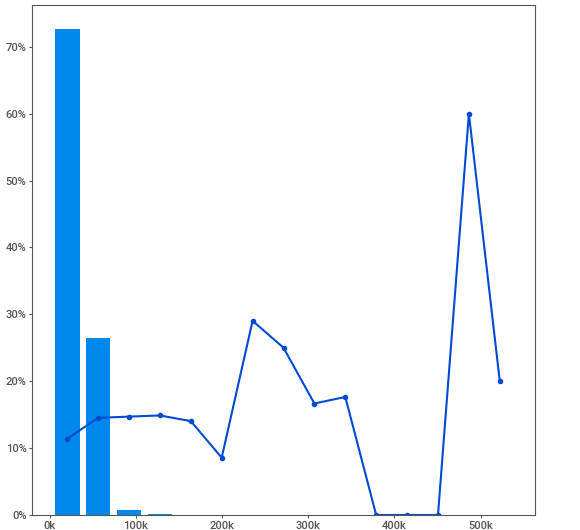
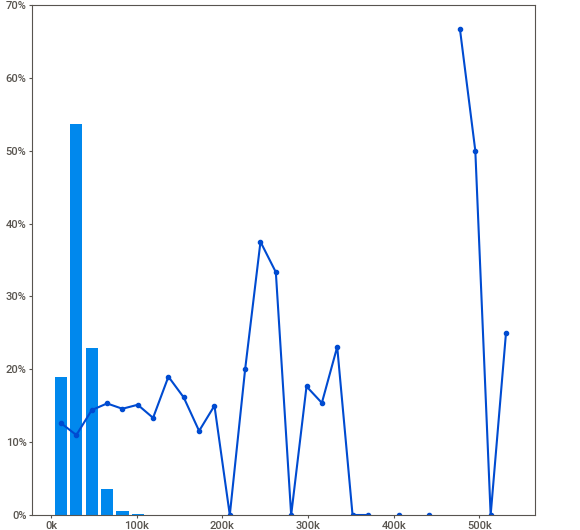
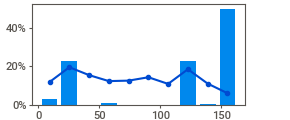
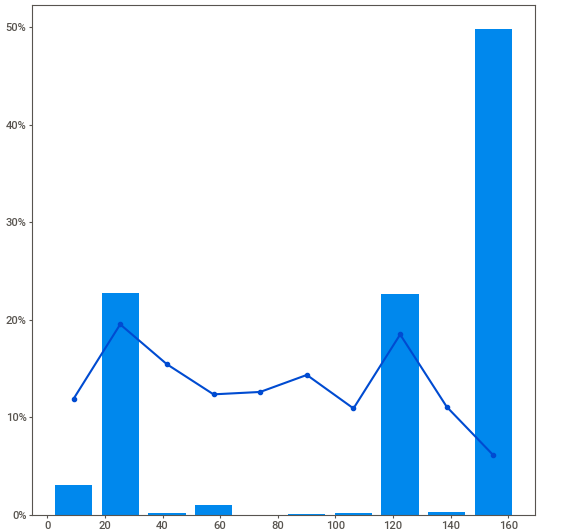
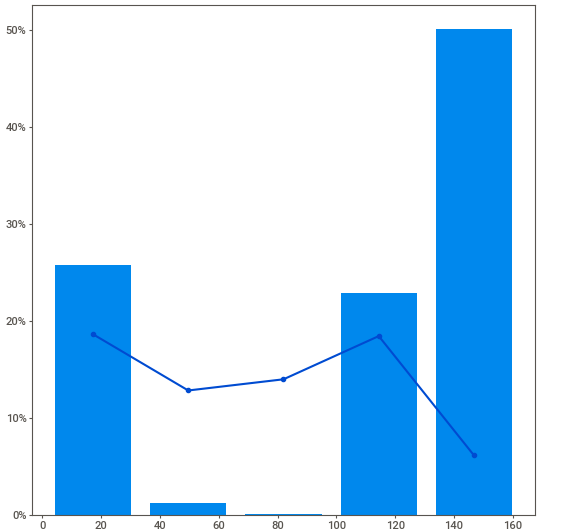
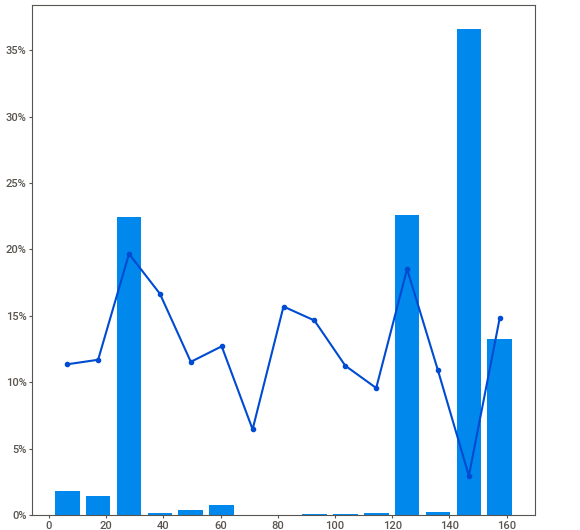
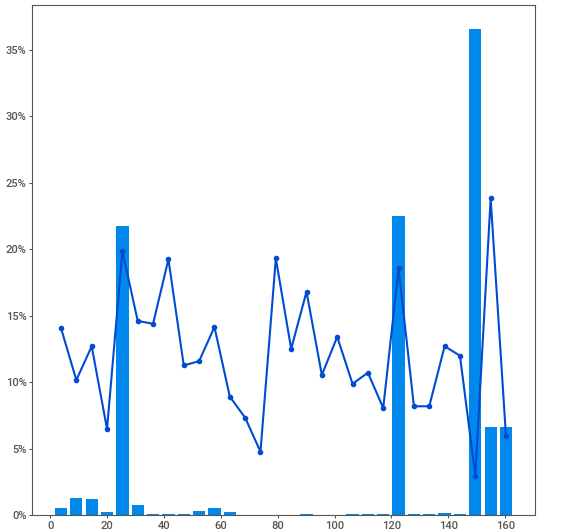
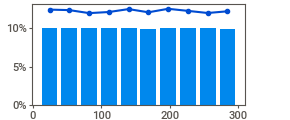
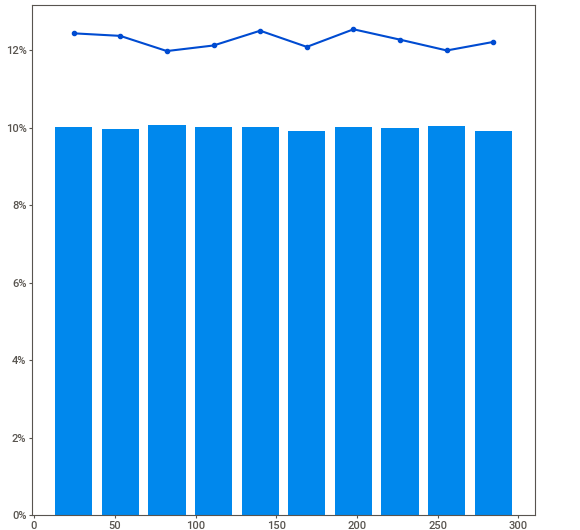
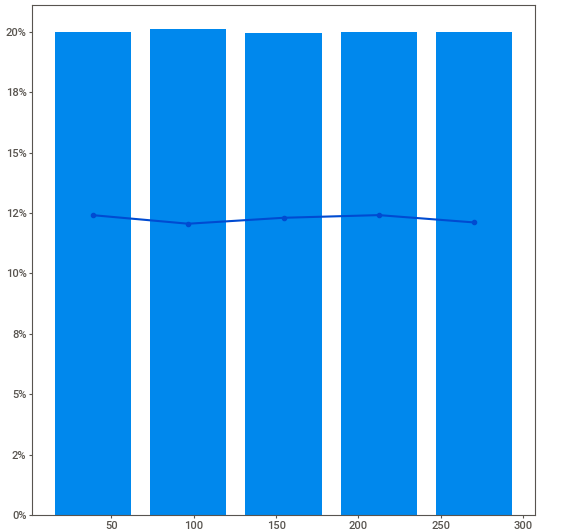
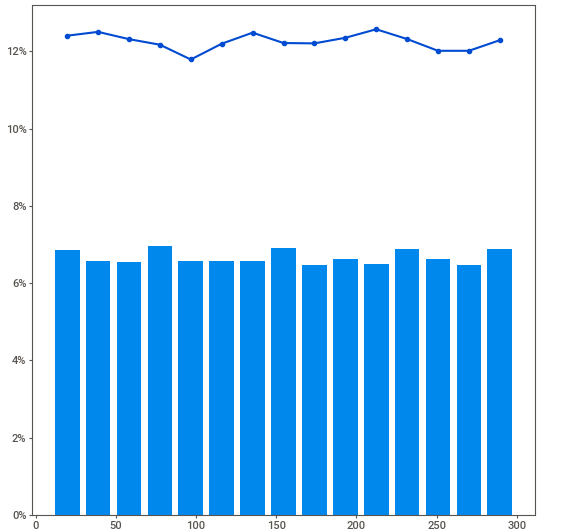
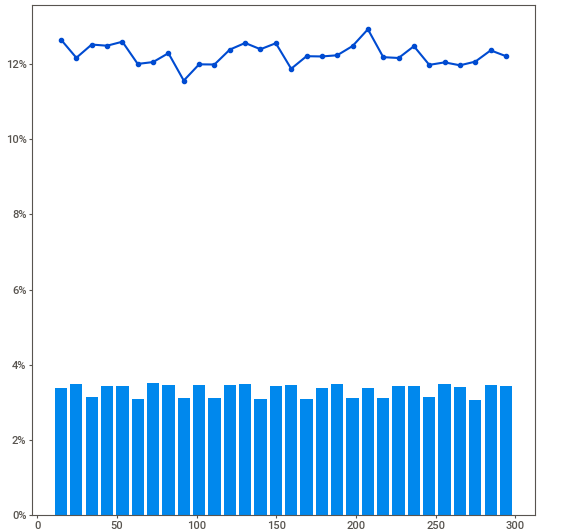
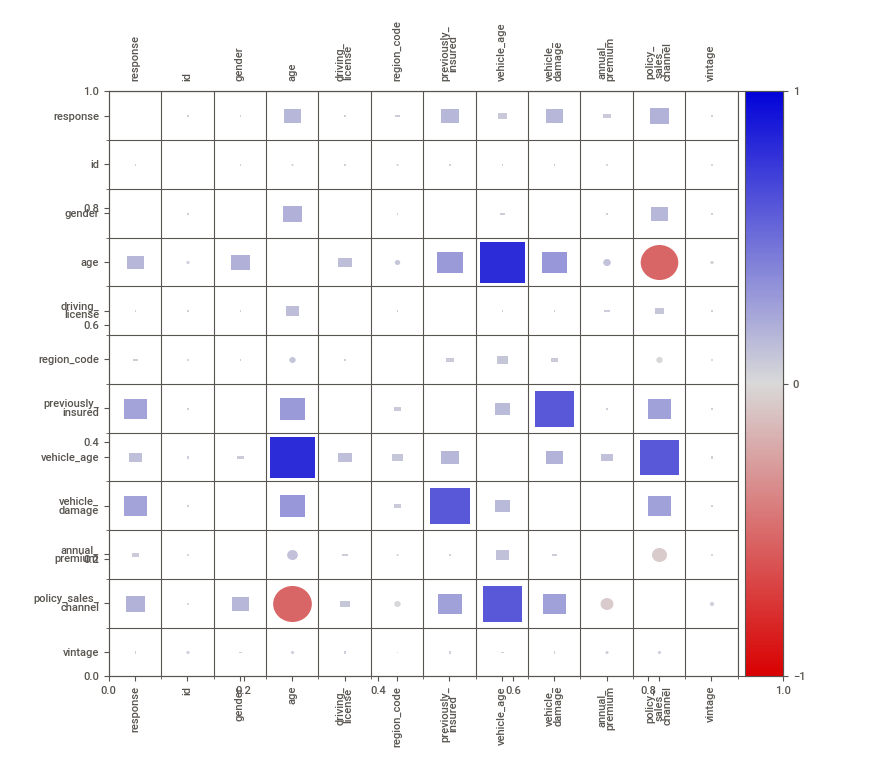
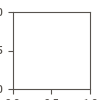

In [35]:
#report = sv.analyze(numericos)
report = sv.analyze(df4,target_feat='response')
report.show_notebook()

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.0 PREPARAÇÃO DOS DADOS</p></div>

In [36]:
df5=df4.copy()

In [37]:
x = df4.drop( 'response', axis=1 )
y = df4['response'].copy() 

x_train, x_val, y_train, y_val = ms.train_test_split( x, y, test_size=0.20 )

df5 = pd.concat( [x_train, y_train], axis=1 )

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.1 Normalização - Standardization</p></div>

In [38]:
df5 = standardization_data (df5)

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.2 Rescaling</p></div>

In [39]:
df5 = rescaling_data (df5)

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.3 Encoding</p></div>

In [40]:
df5 = encoding_data (df5)

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">5.4 Preparação dos Dados de Validação</p></div>

In [41]:
df5_val = pd.concat( [x_val, y_val], axis=1 )

In [42]:
x_val = standardization_data (df5_val)
x_val = rescaling_data (df5_val)
x_val = encoding_data (df5_val)

In [43]:
# fillna
x_val = x_val.fillna( 0 )

In [44]:
df5.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
response                        0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">6.0 SELEÇÃO DE FEATURES</p></div>

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">6.1 Importância das Árvores</p></div>

In [45]:
# model definition
forest = en.ExtraTreesClassifier( n_estimators=1000, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df5.drop( ['id', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

Ranking das Features:
                        feature  importance
0                       vintage    0.272493
0                annual_premium    0.244927
0                           age    0.165193
0                   region_code    0.105144
0                vehicle_damage    0.069335
0          policy_sales_channel    0.059802
0            previously_insured    0.054962
0      vehicle_age_below_1_year    0.013652
0  vehicle_age_between_1_2_year    0.006450
0                        gender    0.005080
0      vehicle_age_over_2_years    0.002500
0               driving_license    0.000461


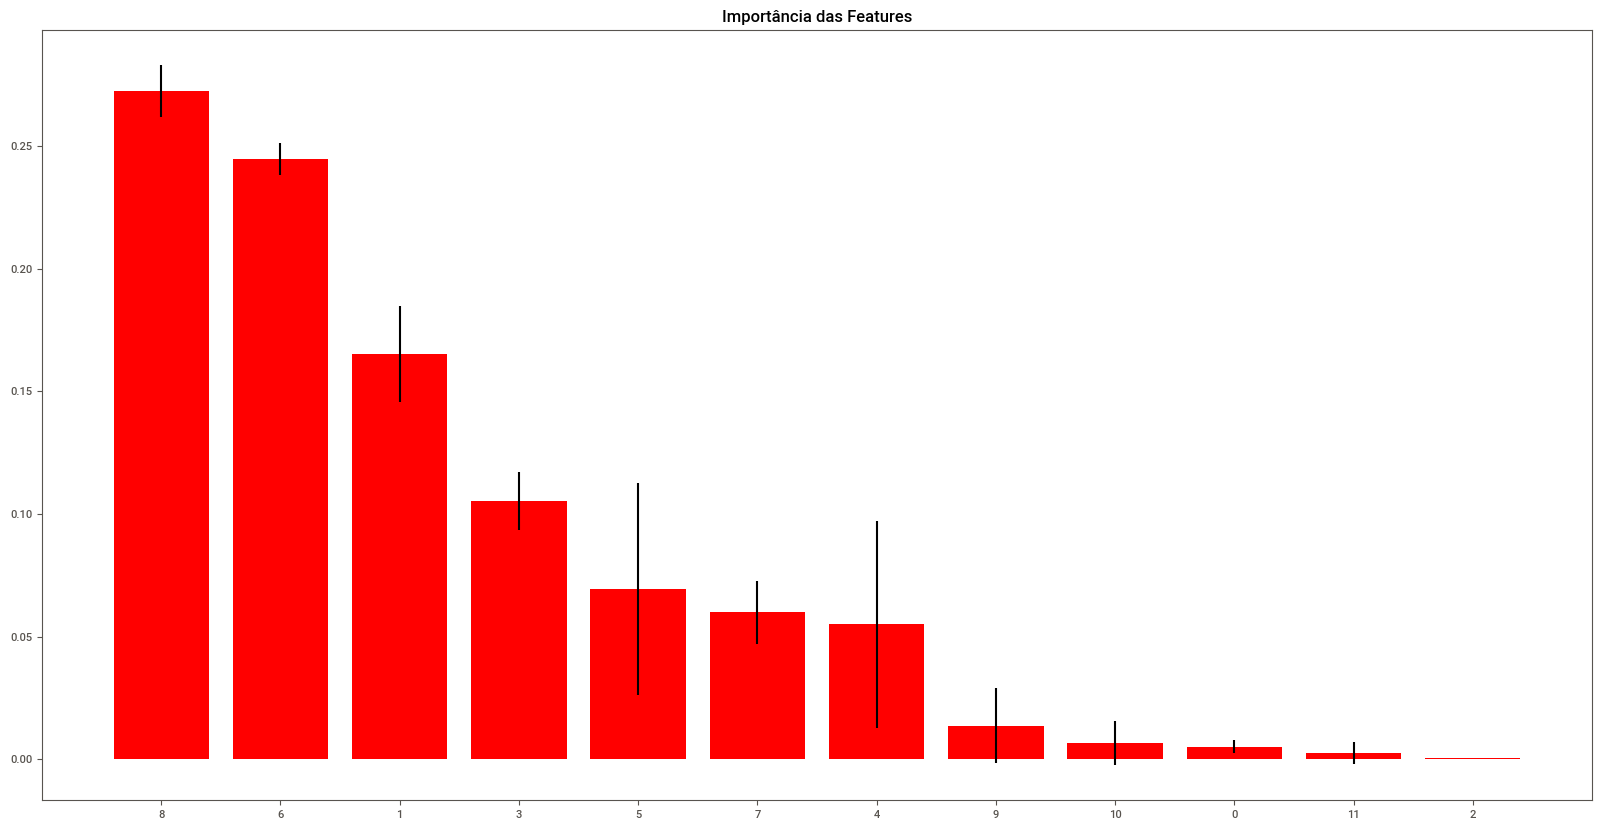

In [46]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Imprimir o Ranking das Features
print("Ranking das Features:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Gráfico de Barras
plt.figure()
plt.title("Importância das Features")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.0 MACHINE LEARNING</p></div>

In [47]:
cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

x_train = df5[ cols_selected ]
x_valid = x_val[ cols_selected ]
y_val = y_val.copy()

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.1 KNN</p></div>

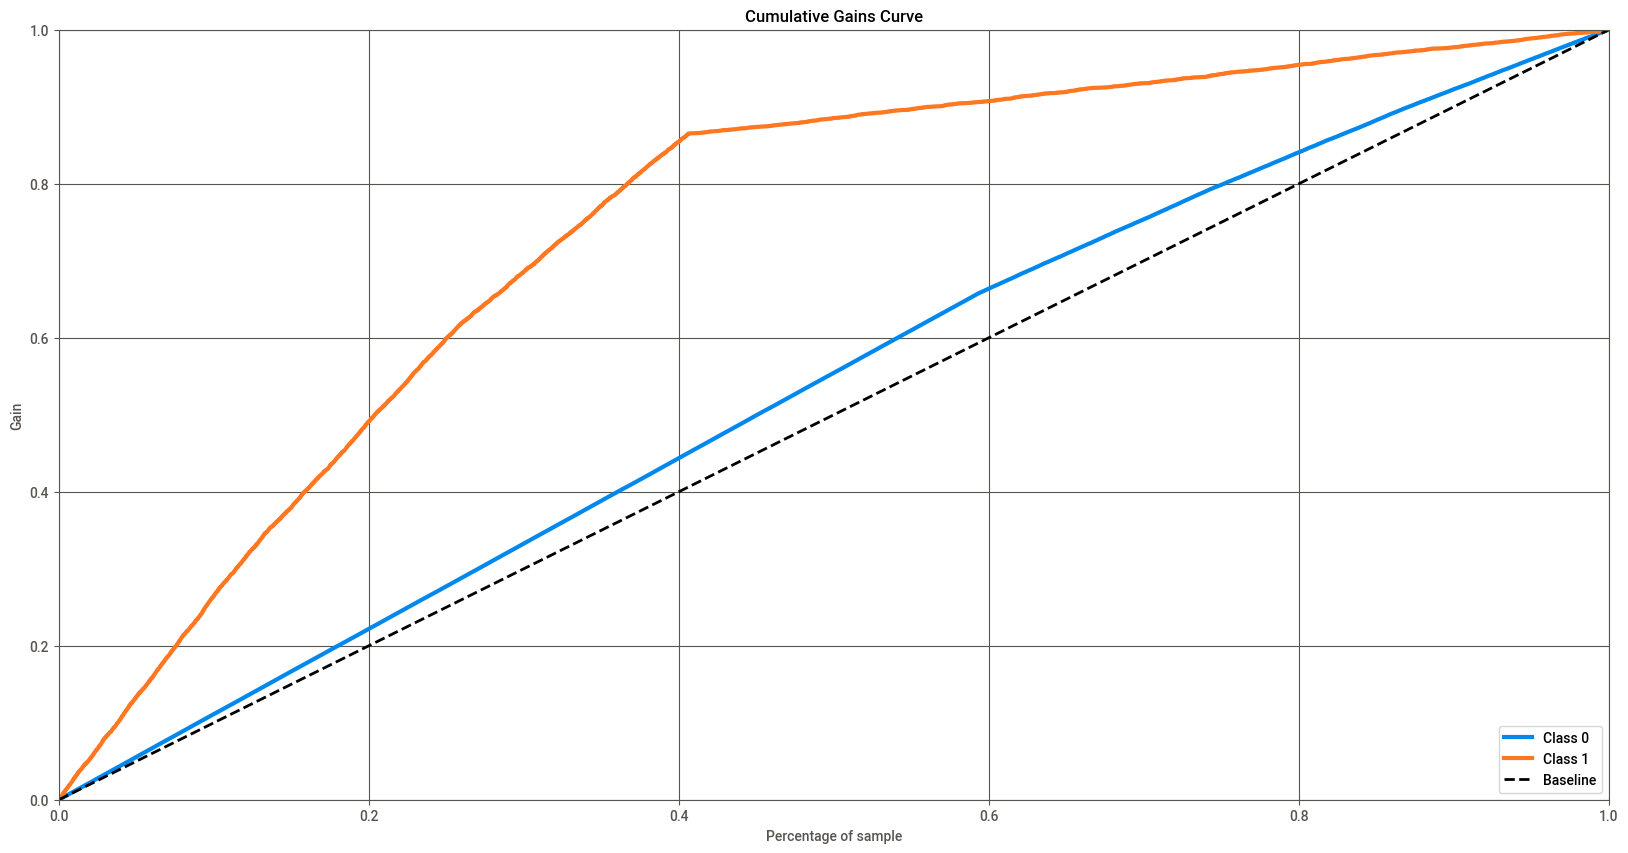

In [48]:
# Definição
knn_model = nh.KNeighborsClassifier( n_neighbors=7 )

# Treinamento
knn_model.fit( x_train, y_train )

# predição
yhat_knn = knn_model.predict_proba( x_valid )

skplt.metrics.plot_cumulative_gain( y_val, yhat_knn );

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.2 REGRESSÃO LOGISTICA</p></div>

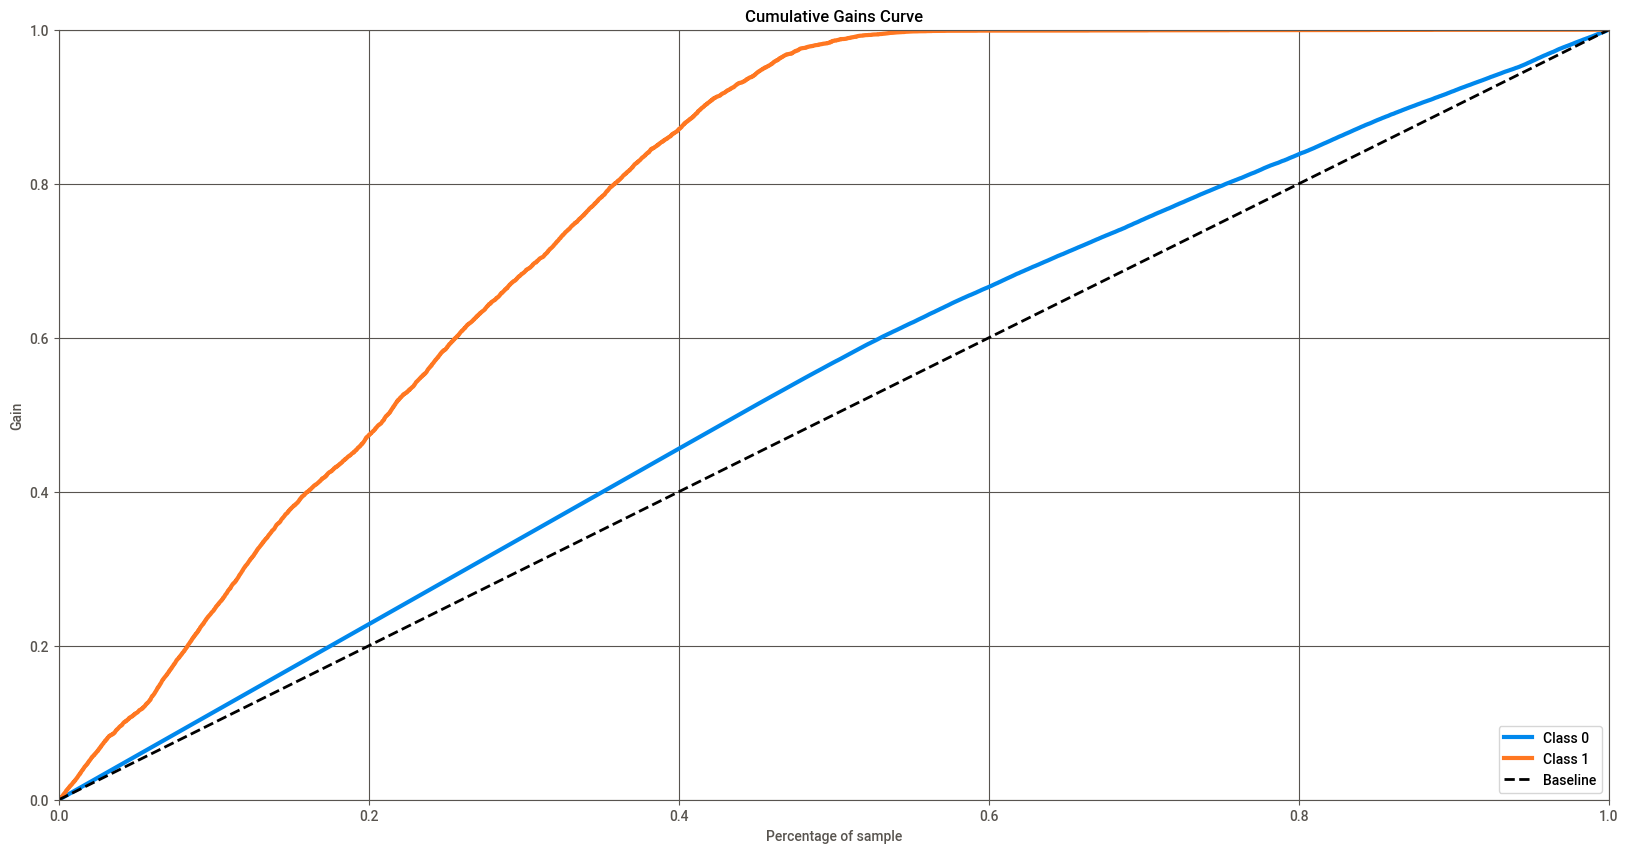

In [49]:
# Definição
lr_model = lm.LogisticRegression( random_state=42 ) 

# Treinamento
lr_model.fit( x_train, y_train )

# Predição
yhat_lr = lr_model.predict_proba( x_valid )

skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.3 RANDOM FOREST</p></div>

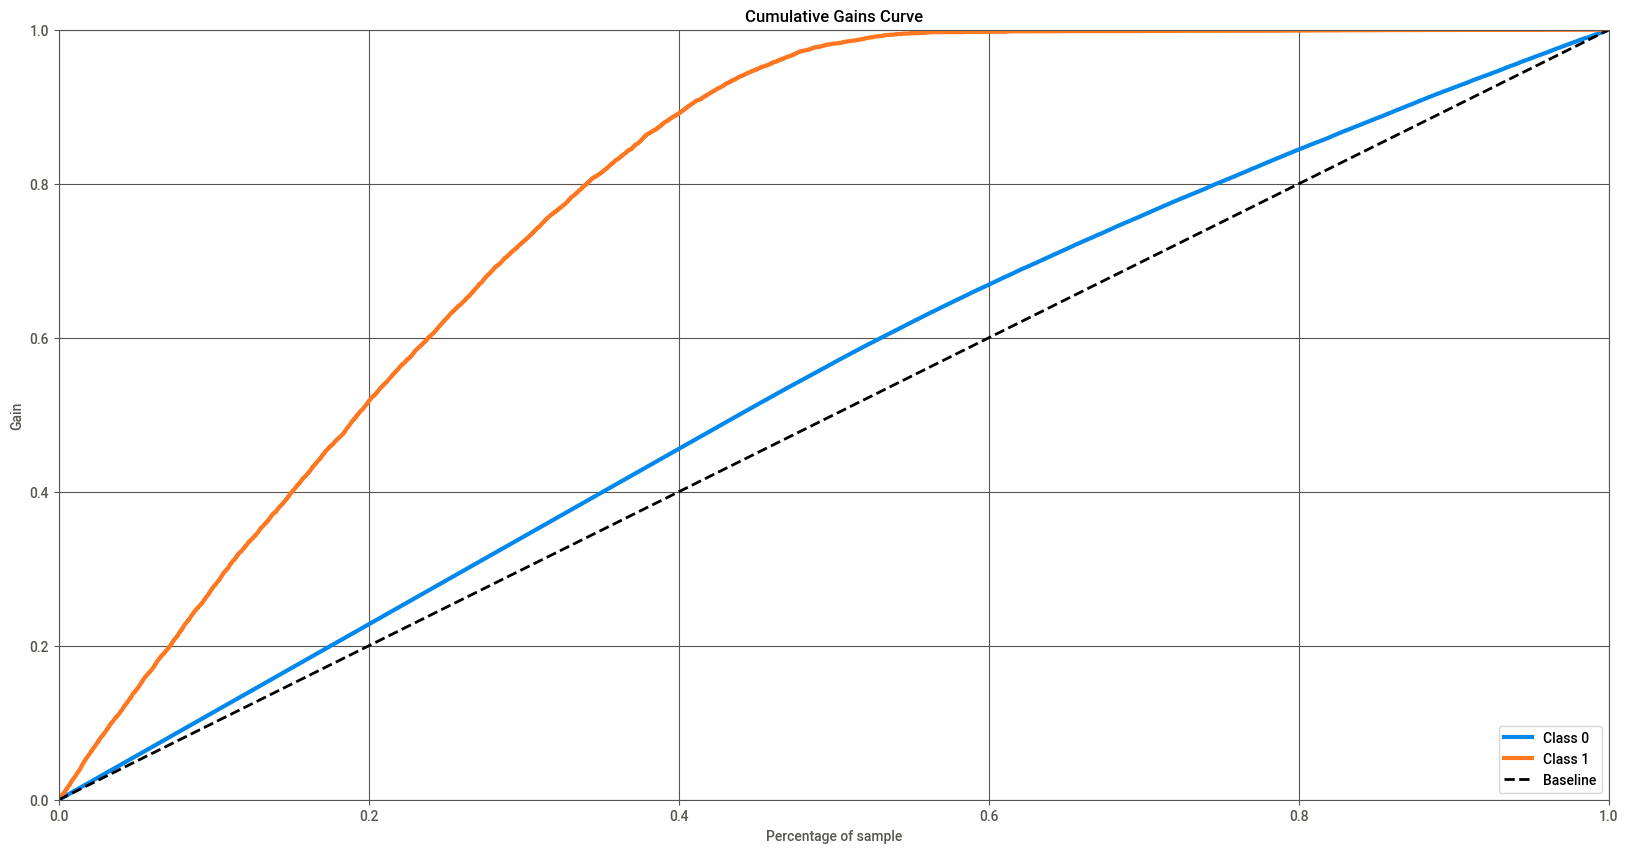

In [50]:
# Definição
rf = en.RandomForestClassifier (n_estimators=1000, n_jobs=1, random_state=42)

# Treinamento
rf.fit( x_train, y_train )

# Predição
yhat_rf = rf.predict_proba( x_valid )

skplt.metrics.plot_cumulative_gain( y_val, yhat_rf );

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">7.4 XGBoost</p></div>

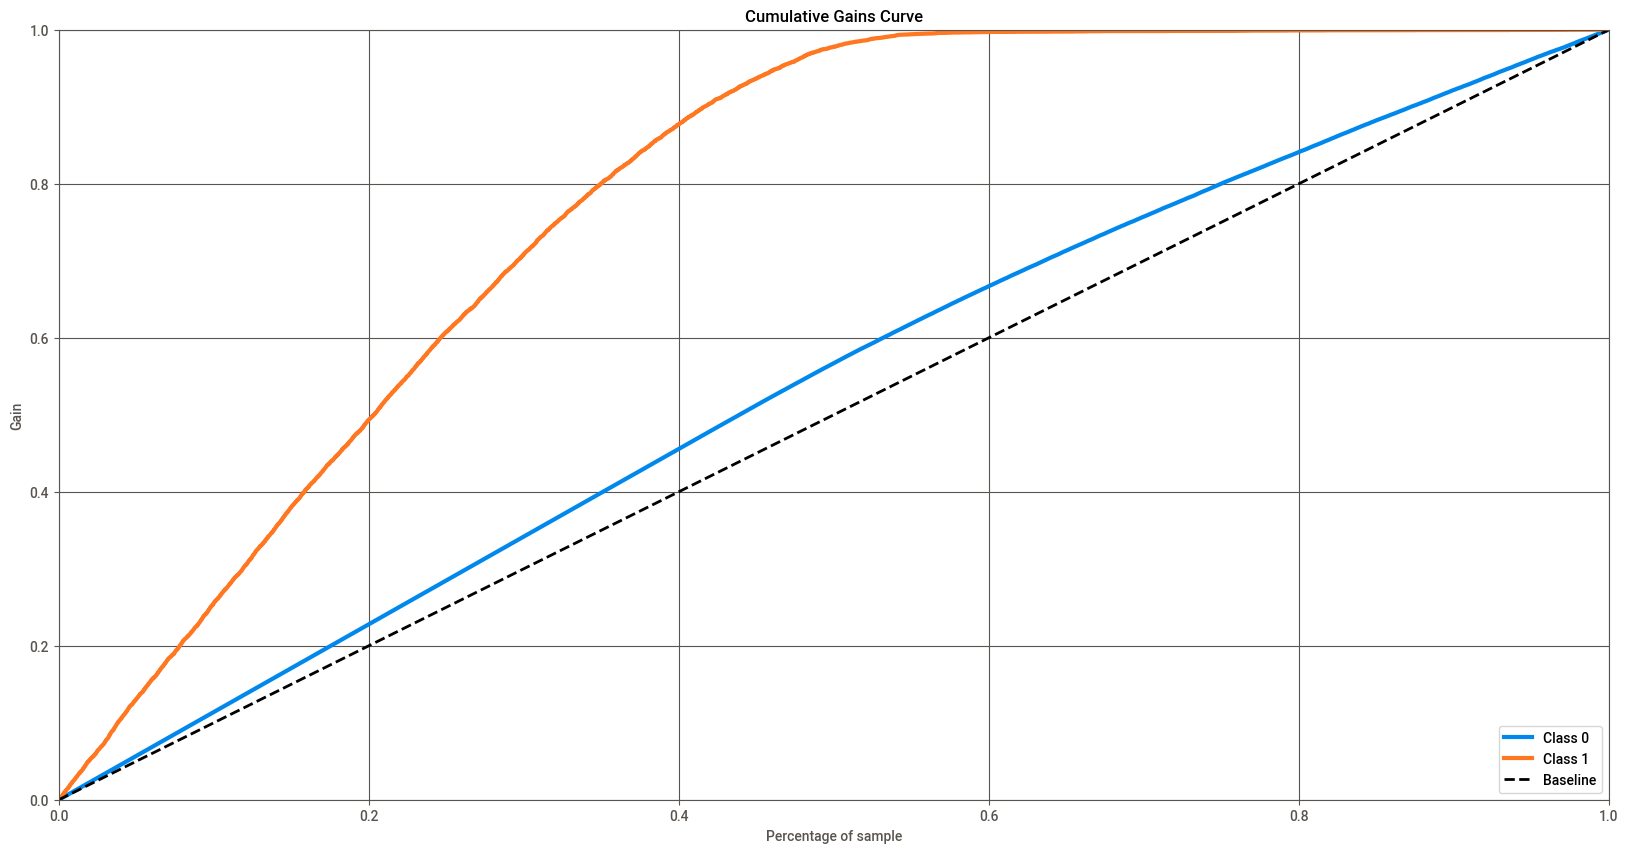

In [51]:
xgb_model = XGBClassifier (n_estimators=1000, n_jobs=1, random_state=42)

# Treinamento
xgb_model.fit( x_train, y_train )

# Predição
yhat_xgb = xgb_model.predict_proba( x_valid )

skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb );

### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">8.0 MODELO DE PERFORMANCE</p></div>

In [52]:
# Tabela com métricas de cada modelo
metrica_knn = modelo_metricas('KNN Classifier', y_val, yhat_knn, x_valid)
metrica_lr = modelo_metricas('Logistic Regression', y_val, yhat_lr, x_valid)
metrica_rf = modelo_metricas('Random Forest Classifier', y_val, yhat_rf, x_valid)
metrica_xgb = modelo_metricas('XGBoost Classifier', y_val, yhat_xgb, x_valid)
metrics_all = pd.concat([metrica_knn, metrica_lr, metrica_rf, metrica_xgb], axis=0)
metrics_all.sort_values(by='Precisão at K', ascending=False)

,Model Name,Precisão at K,Recall at K
0,Random Forest Classifier,0.352162,0.150245
0,KNN Classifier,0.328668,0.140222
0,XGBoost Classifier,0.322169,0.137449
0,Logistic Regression,0.273932,0.116869


### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">8.1 FINE TUNING</p></div>

In [53]:
parametros = {'n_estimators': [1000],
              'max_depth': [3,5,9,12],
              'subsample': [0.1, 0.5,0.75],
              'gamma': [0.1,0.3,0.5,0.75, 1],
              'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
              'min_child_weight' : [3,8,11,15]}

MAX_EVAL = 10

In [54]:
resultado_final = pd.DataFrame()

for i in range(MAX_EVAL):
    lista = {k: random.sample(v, 1)[0] for k, v in parametros.items()}
    print(lista)

    xgb_tuning = XGBClassifier(n_estimators=lista['n_estimators'], 
                               max_depth=lista['max_depth'], 
                               subsample=lista['subsample'],
                               gamma=lista['gamma'],
                               colsample_bytree=lista['colsample_bytree'],
                               min_child_weight=lista['min_child_weight'])
    
    # Treinamento do modelo
    xgb_tuning.fit(x_train, y_train)
    
    # Obtendo as probabilidades previstas
    yhat_proba = xgb_tuning.predict_proba(x_valid)
    
    # Chamando a função modelo_metricas com as probabilidades previstas
    resultado = modelo_metricas('XGBoost Classifier', y_val, yhat_proba, x_valid)
    
    resultado_final = pd.concat([resultado_final, resultado])

resultado_final


{'n_estimators': 1000, 'max_depth': 12, 'subsample': 0.5, 'gamma': 0.75, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 1000, 'max_depth': 12, 'subsample': 0.5, 'gamma': 1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1000, 'max_depth': 12, 'subsample': 0.75, 'gamma': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}
{'n_estimators': 1000, 'max_depth': 12, 'subsample': 0.1, 'gamma': 1, 'colsample_bytree': 0.5, 'min_child_weight': 11}
{'n_estimators': 1000, 'max_depth': 9, 'subsample': 0.5, 'gamma': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 3}
{'n_estimators': 1000, 'max_depth': 3, 'subsample': 0.5, 'gamma': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 8}
{'n_estimators': 1000, 'max_depth': 3, 'subsample': 0.1, 'gamma': 0.75, 'colsample_bytree': 0.3, 'min_child_weight': 3}
{'n_estimators': 1000, 'max_depth': 9, 'subsample': 0.1, 'gamma': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 8}
{'n_estimators': 1000, 'max_depth': 5, 'su

,Model Name,Precisão at K,Recall at K
0,XGBoost Classifier,0.298925,0.127533
0,XGBoost Classifier,0.305174,0.130198
0,XGBoost Classifier,0.304424,0.129878
0,XGBoost Classifier,0.299175,0.127639
0,XGBoost Classifier,0.297426,0.126893
0,XGBoost Classifier,0.357161,0.152378
0,XGBoost Classifier,0.336166,0.143421
0,XGBoost Classifier,0.311422,0.132864
0,XGBoost Classifier,0.321920,0.137343
0,XGBoost Classifier,0.372407,0.158882


### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">8.3 MODELO FINAL</p></div>

In [55]:
parametros_final = {'n_estimators': 1000,
              'max_depth': 3,
              'subsample': 0.5,
              'gamma': 0.1,
              'colsample_bytree': 0.3,
              'min_child_weight' : 15}

In [56]:
# modelo 
modelo_xgb_final = XGBClassifier( n_estimators=parametros_final['n_estimators'], 
                                max_depth=parametros_final['max_depth'], 
                                subsample=parametros_final['subsample'],
                                gamma=parametros_final['gamma'],
                                colsample_bytree=parametros_final['colsample_bytree'],
                                min_child_weight=parametros_final['min_child_weight']).fit(x_train, y_train)

yhat_final = modelo_xgb_final.predict_proba(x_valid)

resultado = modelo_metricas('XGBoost Classifier', y_val, yhat_final, x_valid)
resultado

,Model Name,Precisão at K,Recall at K
0,XGBoost Classifier,0.367908,0.156963


### <div style="color:red;border-radius:25px;background-color:#00008B;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.0 DEPLOY PARA PRODUÇÃO</p></div>

In [57]:
# Salvando o modelo
pickle.dump(modelo_xgb_final, open("C:/Estudos/Comunidade_DS/projetos/PA004/model/modelo_health_insurace_cross_sell.pkl",'wb'))

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.1 Health Insurance Class</p></div>

In [58]:
import pickle
import numpy  as np
import pandas as pd
import inflection

class HealthInsurance (object):
    def __init__ (self):
        self.home_path = "C:/Estudos/Comunidade_DS/projetos/PA004/"
        self.annual_premium_scaler =            pickle.load(open(self.home_path + 'features/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler =                       pickle.load(open(self.home_path + 'features/age_scaler.pkl', 'rb'))
        self.vintage_scaler =                   pickle.load(open(self.home_path + 'features/vintage_scaler.pkl','rb'))
        self.target_encode_gender_scaler =      pickle.load(open(self.home_path + 'features/target_encode_gender_scaler.pkl','rb'))
        self.target_encode_region_code_scaler = pickle.load(open(self.home_path + 'features/target_encode_region_code_scaler.pkl','rb'))
        self.policy_sales_channel_scaler =      pickle.load(open(self.home_path + 'features/freq_policy_sales_channel_scaler.pkl','rb'))

    def limpeza_dados(self,df1):

        # Renomear as colunas para mdoelo snakecase
        cols_old = df1.columns
        snakecase = lambda x: inflection.underscore( x )
        cols_new = list( map( snakecase, cols_old ) )
        df1.columns = cols_new

        return df1

    def feature_engineering(self,df2):

        # vehicle_damage    
        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        # vehicle_age
        df2['vehicle_age'] = df2['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                               else 'between_1_2_year' if x == '1-2 Year' 
                                               else 'below_1_year' ) 


        return df2

    def preparacao (self,df5):

        # annual_premium (por causa do gráfico)
        df5['annual_premium'] = self.annual_premium_scaler.transform(df5[['annual_premium']].values)

        # age (por causa do gráfico)
        df5['age'] =  self.age_scaler.transform(df5[['age']].values)

        # vintage (por causa do gráfico)
        df5['vintage'] = self.vintage_scaler.transform(df5[['vintage']].values)

        # gender - Target Encoding / One Hot Encoding 
        df5.loc[:,'gender'] = df5['gender'].map(self.target_encode_gender_scaler)

        # region_code (eu achava que era rescaling) -  Target Encoding / Frequency Encoding
        df5.loc[:,'region_code'] = df5['region_code'].map(self.target_encode_region_code_scaler).astype(int)

        # vehicle_age (variavel categórica)  One Hot Encoding / Order Encoding / Frequency Encoding
        df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

        # policy_sales_channel (eu achava que era rescaling) - Frequency Encoding / Target Encoding
        df5.loc[:,'policy_sales_channel'] = df5['policy_sales_channel'].map(self.policy_sales_channel_scaler)

        #Feature Selection
        cols_selected = ['annual_premium', 'vintage', 'age', 'region_code', 'vehicle_damage', 'previously_insured',
                 'policy_sales_channel']

        return df5[cols_selected]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict_proba( test_data )
            
        # join pred into the original data
        original_data['prediction'] = pred
            
        return original_data.to_json( orient='records', date_format='iso' ) 



### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.2 API Handler</p></div>

In [59]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance

# carregar o modelo atual
path = "C:/Estudos/Comunidade_DS/projetos/PA004/"
modelo = pickle.load(open (path + 'model/modelo_health_insurace_cross_sell.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/predict', methods=['POST'] )

def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )

        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )

        # Instantiate Rossmann class
        pipeline = HealthInsurance()

        # data cleaning
        df1 = pipeline.limpeza_dados( test_raw )

        # feature engineering
        df2 = pipeline.feature_engineering( df1 )

        # data preparation
        df3 = pipeline.preparacao( df2 )

        # prediction
        df_response = pipeline.get_prediction( modelo, test_raw, df3 )

        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' , debug=True )

ModuleNotFoundError: No module named 'healthinsurance'

### <div style="color:red;border-radius:25px;background-color:#4169E1;letter-spacing:0.2px;overflow:hidden"><p style="padding:10px;color:white;overflow:hidden;text-align: center;margin:0;font-size:100%">9.3 Teste da API</p></div>

In [68]:
import requests

In [69]:
# carregar datasets de teste e o dataset da colna response
df_test = pd.read_csv( '../datasets/test.csv', low_memory=False )
response_test = pd.read_csv( '../datasets/sample_submission.csv', low_memory=False )
response_column = response_test['Response']
df_test['Response'] = response_column


In [70]:
df_test = df_test.sample(10)

In [71]:
# convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [72]:
# API Call
url = 'http://localhost:5000/predict'
#url = 'https://health-insurance-iuo5.onrender.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [73]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )

In [74]:
d1

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction
0,480463,0.138889,0.261538,1,0.106045,0,between_1_2_year,0,-1.627149,0.194288,0.564014,0,0.051168
1,386232,0.104223,0.123077,1,0.038685,1,below_1_year,0,-0.056645,0.351880,0.425606,0,0.000238
2,414049,0.138889,0.323077,1,0.187535,0,between_1_2_year,1,0.805793,0.208614,0.363322,0,0.284070
3,394915,0.138889,0.323077,1,0.117772,0,between_1_2_year,1,0.468703,0.208614,0.813149,0,0.177625
4,440063,0.138889,0.046154,1,0.117324,1,below_1_year,0,-0.673439,0.351880,0.169550,0,0.000191
5,494420,0.138889,0.353846,1,0.187535,0,between_1_2_year,1,1.478050,0.208614,0.809689,0,0.325609
6,423817,0.104223,0.784615,1,0.097053,0,over_2_years,1,0.958126,0.028260,0.176471,0,0.173289
7,393682,0.104223,0.861538,1,0.187535,1,between_1_2_year,0,0.456222,0.208614,0.996540,0,0.000075
8,418293,0.138889,0.153846,1,0.133862,1,below_1_year,1,-1.627149,0.028260,0.193772,0,0.008306
9,405125,0.104223,0.892308,1,0.098291,1,between_1_2_year,0,0.609021,0.208614,0.996540,0,0.000047


In [67]:
d1.sort_values( 'prediction', ascending=False ).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,prediction
3,467308,0.104223,0.338462,1,0.187535,0,between_1_2_year,1,-1.627149,26.0,0.754325,0,0.288582
9,486733,0.104223,0.630769,1,0.136465,0,between_1_2_year,1,0.038358,124.0,0.103806,0,0.281948
7,482840,0.104223,0.446154,1,0.187535,0,between_1_2_year,1,0.068452,26.0,0.266436,0,0.224494
6,408446,0.104223,0.723077,1,0.187535,0,between_1_2_year,1,2.140159,122.0,0.339100,0,0.184492
4,474071,0.104223,0.707692,1,0.187535,0,between_1_2_year,1,0.567322,26.0,0.937716,0,0.131952
